# Correlation of class switch decisions among related cells

# Setup

In [1]:
output_dir = "/quakestor4/rfhorns/Bcell_class_switching/figures/v5"
output_suffix = ""
output_format = ".png"
output_format2 = ".pdf"

output_formats = [output_format, output_format2]

In [2]:
import time
import itertools
import copy
import json
import MySQLdb

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

import seaborn as sns


Bad key "axes.prop_cycle" on line 2 in
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/seaborn-pastel.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.prop_cycle" on line 2 in
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/seaborn-deep.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.spines.right" on line 210 in
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.flierprops.linewidth" on line 321 in
/local10G/rfhorns/resources/a

In [3]:
# Plot settings
sns.set(style="darkgrid")

fig_scale = 4

matplotlib.rc('font', size=18)
matplotlib.rc('text', usetex=False)
matplotlib.rc('savefig', dpi=150)

np.set_printoptions(suppress=True, precision=2) # string format

# Isotype to color map
path_to_isotype_to_color_map = "/datastore/rfhorns/resources/immune/isotype_to_color_dict.json"
with open(path_to_isotype_to_color_map, 'rU') as f:
    isotype_to_color = json.load(f)
    
# Isotype to position/uid map
isotype_names = ['Naive', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgE', 'IgA2']
isotype_to_uid = dict(zip(isotype_names,range(len(isotype_names))))

# Saving figures
def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

def modifyAxesFelix(ax, ticklabels=False):
    ''' Removes top and right axes. Shifts left axis by 5pt '''
    if ticklabels:
        ax.get_xaxis().set_ticks_position('bottom')
        ax.get_yaxis().set_ticks_position('left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward',5))
    ax.spines['bottom'].set_position(('outward',5))

# Load genealogical data 

In [4]:
def load_df(d):
    col_names = ["mrca_uid", "mrca_isotype",
                "sib1_uid", "sib1", "isotype_sib1",
                "sib2_uid", "sib2", "isotype_sib2",
                "kinship", "dist1", "dist2",
                "sib1_switch_uid", "sib1_switch_id", "sib1_switch_isotype",
                "sib1_switch_steps", "sib1_switch_dist",
                "sib2_switch_uid", "sib2_switch_id", "sib2_switch_isotype",
                "sib2_switch_steps", "sib2_switch_dist"]
    df = pd.io.parsers.read_table(d+"/sibs.clean.txt", names=col_names, header=None)
    return df

def replace_naive(df):

    naive_isotypes = ["IgM", "IgD"]
    naive_label = "Naive"

    df_naive = df.copy()
    df_naive.mrca_isotype[df.mrca_isotype.isin(naive_isotypes)] = naive_label
    df_naive.isotype_sib1[df.isotype_sib1.isin(naive_isotypes)] = naive_label
    df_naive.isotype_sib2[df.isotype_sib2.isin(naive_isotypes)] = naive_label
    df_naive.sib1_switch_isotype[df.sib1_switch_isotype.isin(naive_isotypes)] = naive_label
    df_naive.sib2_switch_isotype[df.sib2_switch_isotype.isin(naive_isotypes)] = naive_label

    return df_naive

def filter_df(df):
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered.mrca_isotype == df_filtered.isotype_sib1]
    df_filtered = df_filtered[(df_filtered.sib1_switch_isotype != df_filtered.isotype_sib1) & (df_filtered.sib2_switch_isotype != df_filtered.isotype_sib1)]
#    df_filtered = df_filtered[np.absolute(df_filtered.dist_to_mrca1 - df_filtered.dist_to_mrca2) < 7]
    return df_filtered

def drop_redundant_cols(df):
    df_pruned = df.copy()
    df_pruned.drop("sib1", axis=1, inplace=True)
    df_pruned.drop("sib2", axis=1, inplace=True)
    df_pruned.drop("sib1_switch_id", axis=1, inplace=True)
    df_pruned.drop("sib2_switch_id", axis=1, inplace=True)
    return df_pruned

def append_clustering(df):
    clustering_num = [int(str(x)[-9]) for x in list(df["mrca_uid"])]
    df["clustering_num"] = clustering_num
    return df

def load_filtered_df(d):
    df = drop_redundant_cols(filter_df(replace_naive(load_df(d))))
    df = append_clustering(df)
    df = df[df["clustering_num"] == 1]
    print "Pairs of related cells:", df.shape[0]
    return df

In [5]:
# With max_lineage_num_unique_seqs = 2500, expect 9,430 pairs.
# With max_lineage_num_unique_seqs = 5000, expect 24,470 pairs.
input_dir_V1 = "/local10G/rfhorns/Bcell_class_switching_V1_v3/figures/data3"
df_V1 = load_filtered_df(input_dir_V1)

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.p

Pairs of related cells: 152226


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# With max_lineage_num_unique_seqs = 2500 or 5000, expect 14,537 pairs.
input_dir_V3 = "/local10G/rfhorns/Bcell_class_switching_V3_v3/figures/data3"
df_V3 = load_filtered_df(input_dir_V3)

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.p

Pairs of related cells: 186607


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Inspect data

In [7]:
df_V1

mrca_uid mrca_isotype            sib1_uid isotype_sib1  \
0        60102010100060012         IgA1   60102010100048619         IgA1   
1        10102010100000732         IgG2   10102010100000732         IgG2   
2       130102010100015531         IgA1  130102010100015531         IgA1   
3       130102010100046998        Naive  130102010100046998        Naive   
4       240102010100010953        Naive  240102010100010953        Naive   
5       240102010100019743        Naive  240102010100019743        Naive   
6       240102010100034438         IgG1  240102010100034438         IgG1   
7       140102010100111462        Naive  140102010100050519        Naive   
8        20102010100045028         IgG1   20102010100045028         IgG1   
9        20102010100007969        Naive   20102010100007969        Naive   
10       20102010100020203         IgG2   20102010100020203         IgG2   
11      230102010100099255        Naive  230102010100099255        Naive   
12      230102010100066858        Naive  230102010100105819        Naive   
13       80102010100150498         IgA1   80102010100012826         IgA1   
14       80102010100000783        Naive   80102010100000783        Naive   
15       80102010100119775        Naive   80102010100000783        Naive   
16       80102010100013057        Naive   80102010100000783        Naive   
17       80102010100013057        Naive   80102010100000783        Naive   
18       80102010100013057        Naive   80102010100000783        Naive   
19       80102010100000783        Naive   80102010100000783        Naive   
20       80102010100049042        Naive   80102010100049042        Naive   
21       80102010100007418        Naive   80102010100007418        Naive   
22       80102010100172651        Naive   80102010100172651        Naive   
23       80102010100172651        Naive   80102010100172651        Naive   
24       80102010100119775        Naive   80102010100066285        Naive   
25       80102010100013057        Naive   80102010100066285        Naive   
26       80102010100013057        Naive   80102010100066285        Naive   
27       80102010100013057        Naive   80102010100066285        Naive   
28       80102010100057027        Naive   80102010100066285        Naive   
29       80102010100148575        Naive   80102010100148575        Naive   
...                    ...          ...                 ...          ...   
199635  200102010100065561        Naive  200102010100069099        Naive   
199637  200102010100086995        Naive  200102010100086995        Naive   
199638  200102010100065561        Naive  200102010100086995        Naive   
199641  200102010100065561        Naive  200102010100072712        Naive   
199642  200102010100032280        Naive  200102010100032280        Naive   
199643  200102010100032280        Naive  200102010100032280        Naive   
199644  200102010100032280        Naive  200102010100032280        Naive   
199645  200102010100023438        Naive  200102010100023438        Naive   
199646  200102010100023438        Naive  200102010100023438        Naive   
199647  200102010100007713        Naive  200102010100087749        Naive   
199648  160102010100097658         IgG1  160102010100097658         IgG1   
199649  160102010100017399        Naive  160102010100017399        Naive   
199650  160102010100017155        Naive  160102010100017399        Naive   
199651  160102010100017155        Naive  160102010100242680        Naive   
199652  190102010100081690        Naive  190102010100100053        Naive   
199653  190102010100214990         IgG3  190102010100214990         IgG3   
199655  150102010100222066         IgG1  150102010100254641         IgG1   
199656  150102010100241222         IgG1  150102010100254641         IgG1   
199657  150102010100071425         IgG1  150102010100254641         IgG1   
199658  150102010100241222         IgG1  150102010100222066         IgG1   
199659  150102010100071425         IgG1  150102010100222066       

# Check if any sisters are in fact the same cell

In [468]:
np.sum(df_V1["sib1_uid"] == df_V1["sib2_uid"]) # Count of sisters that have the same uid. Zero -- good.

0

# Filter for pairs with inherited mutations

In [11]:
# Load mutations from SQL
def load_muts_df(visit):

    db = MySQLdb.connect(host="scigc-vm-47", # your host, usually localhost
                         user="rfhorns", # your username
                         passwd="immuno", # your password
                         db="Bcell_flu_twins_" + visit + "_v3") # name of the data base
    
    query = """
        SELECT s.uid, s.mut_germline_positions, s.mut_germline_before, s.mut_germline_after
        FROM sequences s, clusterings c, lineages l
        WHERE s.lineage_uid = l.uid
        AND l.num_unique_seqs > 2
        AND s.clustering_uid = c.uid
        AND c.clustering_CDR3_similarity_cutoff < 0.96
        AND c.clustering_CDR3_similarity_cutoff > 0.94
        """

    print "Loading data..."
    start_time = time.time()

    df = pd.io.sql.read_sql(query, db)

    if df.shape[0] == 0:
        print "Error: no rows loaded"

    elapsed_time = time.time() - start_time
    print "Wall clock time", elapsed_time
    print
    
    return df

In [12]:
df_muts_V1 = load_muts_df("V1")
df_muts_V1.set_index("uid", inplace=True)
print df_muts_V1.shape

Loading data...
Wall clock time 128.662531137

(2529387, 3)


In [13]:
df_muts_V3 = load_muts_df("V3")
df_muts_V3.set_index("uid", inplace=True)
print df_muts_V3.shape

Loading data...
Wall clock time 44.774296999

(2088005, 3)


In [14]:
def append_mut_germline_data(df, df_muts):
    """ Get germline mutations of each sequence """
    
    names = ["mrca", "sib1", "sib2", "sib1_switch", "sib2_switch"]
    
    for name in names:
        x = df_muts.loc[df[name + "_uid"]]
        x.columns = [name + "_" + s for s in list(x.columns)]
        x["index"] = df.index
        x.set_index("index", inplace=True, drop=True)
        df = pd.concat([df, x], axis=1, join="inner")
    
    return df

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def mutStrToSet(s):
    if isfloat(s):
        return set([])
    else:
        return set(s.split(","))

def call_sequential_muts(df):
    """ Add flag indicating whether each descendant inherits all mutations from ancestor. """
    
    has_sequential_muts = []
    
    for i, row in df.iterrows():
        
        mrca = mutStrToSet(row["mrca_mut_germline_positions"])
        sib1 = mutStrToSet(row["sib1_mut_germline_positions"])
        sib2 = mutStrToSet(row["sib2_mut_germline_positions"])
        sib1_switch = mutStrToSet(row["sib1_switch_mut_germline_positions"])
        sib2_switch = mutStrToSet(row["sib2_switch_mut_germline_positions"])
        
        if mrca <= sib1 and mrca <= sib2 and sib1 <= sib1_switch and sib2 <= sib2_switch:
            s = 1
        else:
            s = 0
            
        has_sequential_muts.append(s)
        
    df["has_sequential_muts"] = has_sequential_muts

    return df

In [15]:
df_V1 = append_mut_germline_data(df_V1, df_muts_V1)
df_V1 = call_sequential_muts(df_V1)
df_V1 = df_V1[df_V1["has_sequential_muts"] == 1]
print df_V1.shape

(16531, 34)


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_V3 = append_mut_germline_data(df_V3, df_muts_V3)
df_V3 = call_sequential_muts(df_V3)
df_V3 = df_V3[df_V3["has_sequential_muts"] == 1]
print df_V3.shape

(23669, 34)


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
df_V1.head()

mrca_uid mrca_isotype           sib1_uid isotype_sib1  \
1   10102010100000732         IgG2  10102010100000732         IgG2   
8   20102010100045028         IgG1  20102010100045028         IgG1   
9   20102010100007969        Naive  20102010100007969        Naive   
13  80102010100150498         IgA1  80102010100012826         IgA1   
20  80102010100049042        Naive  80102010100049042        Naive   

             sib2_uid isotype_sib2  kinship  dist1  dist2    sib1_switch_uid  \
1   10102010100014917         IgG2        0      0      1  10102010100044786   
8   20102010100127714         IgG1        0      0      3  20102010100054519   
9   20102010100089310        Naive        0      0      1  20102010100095510   
13  80102010100150498         IgA1        1      1      0  80102010100099849   
20  80102010100089285        Naive        0      0      1  80102010100143332   

           ...                                sib2_mut_germline_positions  \
1          ...          V33,V37,V56,V76,V82,V89,V92,V94,V142,V164,V172...   
8          ...          V40,V75,V83,V89,V91,V92,V98,V104,V132,V148,V15...   
9          ...                                            V68,V85,J13,J14   
13         ...                                                   V191,J11   
20         ...                       V16,V29,V142,V150,V173,V223,V241,J10   

                           sib2_mut_germline_before  \
1               G,A,G,G,A,G,A,G,G,C,G,A,C,A,G,G,G,G   
8   C,T,C,G,A,G,C,G,G,G,G,G,G,G,C,C,A,C,A,C,C,G,A,G   
9                                           C,T,A,C   
13                                              A,C   
20                                  G,G,G,C,T,G,C,A   

                            sib2_mut_germline_after  \
1               T,G,A,A,C,C,C,A,C,G,T,G,G,G,A,T,A,C   
8   T,C,A,T,G,A,G,C,A,T,C,C,A,C,T,T,T,T,G,T,T,A,T,C   
9                                           T,C,G,G   
13                                              T,T   
20                                  C,A,C,T,C,T,T,G   

                   sib1_switch_mut_germline_positions  \
1   V33,V37,V56,V76,V82,V89,V92,V94,V142,V159,V164...   
8   V40,V75,V83,V89,V92,V98,V104,V132,V148,V158,V1...   
9                                     V68,V85,J13,J14   
13                                      V173,V191,J11   
20               V16,V29,V142,V150,V173,V223,V241,J10   

                  sib1_switch_mut_germline_before  \
1         G,A,G,G,A,G,A,G,G,C,C,G,A,C,T,A,G,G,G,G   
8   C,T,C,G,G,C,G,G,G,G,G,G,G,C,C,A,C,A,C,C,G,A,G   
9                                         C,T,A,C   
13                                          A,A,C   
20                                G,G,G,C,T,G,C,A   

                   sib1_switch_mut_germline_after  \
1         T,G,A,A,C,C,C,A,C,T,G,T,G,G,G,G,A,T,A,C   
8   T,C,A,T,A,G,C,A,T,C,C,A,C,T,T,T,T,G,T,T,A,T,C   
9                                         T,C,G,G   
13                                          G,T,T   
20                                C,A,C,T,C,T,T,G   

                   sib2_switch_mut_germline_positions  \
1   V33,V37,V56,V76,V82,V89,V92,V94,V142,V159,V164...   
8   V40,V75,V83,V89,V91,V92,V98,V104,V132,V148,V15...   
9                                     V68,V85,J13,J14   
13                                      V173,V191,J11   
20               V16,V29,V142,V150,V173,V223,V241,J10   

                    sib2_switch_mut_germline_before  \
1           G,A,G,G,A,G,A,G,G,C,C,G,A,C,T,A,G,G,G,G   
8   C,T,C,G,A,G,C,G,G,G,G,G,G,G,C,C,A,C,A,C,C,G,A,G   
9                                           C,T,A,C   
13                                            A,A,C   
20                                  G,G,G,C,T,G,C,A   

                     sib2_switch_mut_germline_after has_sequential_muts  
1           T,G,A,A,C,C,C,A,C,T,G,T,G,G,G,G,A,T,A,C                   1  
8   T,C,A,T,G,A,G,C,A,T,C,C,A,C,T,T,T,T,G,T,T,A,T,C                   1  
9                                           T,C,G,G                   1  
13                                 

In [18]:
# Show example of sibling pair with sequential mutations
df_V1[df_V1["has_sequential_muts"] == 1].iloc[2]

mrca_uid                              20102010100007969
mrca_isotype                                      Naive
sib1_uid                              20102010100007969
isotype_sib1                                      Naive
sib2_uid                              20102010100089310
isotype_sib2                                      Naive
kinship                                               0
dist1                                                 0
dist2                                                 1
sib1_switch_uid                       20102010100095510
sib1_switch_isotype                                IgA2
sib1_switch_steps                                     1
sib1_switch_dist                                      1
sib2_switch_uid                       20102010100095510
sib2_switch_isotype                                IgA2
sib2_switch_steps                                     0
sib2_switch_dist                                      0
clustering_num                                  

# Calculate mutational distances 

In [19]:
def calc_mut_dists(df):
    df["mean_sib_dist"] = df.dist1 + df.dist2 / 2
    df["max_sib_dist"] = np.array([max(x1, x2) for x1, x2 in zip(list(df.dist1), list(df.dist2))])
    return df

In [20]:
df_V1 = calc_mut_dists(df_V1)
df_V3 = calc_mut_dists(df_V3)

# Save dataframes

In [6]:
import pickle

In [23]:
# Save
outfile_name = "/quakestor4/rfhorns/Bcell_class_switching/figures/v4" + "/sibs_filter_df_V1.pickle"
with open(outfile_name, 'w') as f:
    pickle.dump(df_V1, f)
    
outfile_name = "/quakestor4/rfhorns/Bcell_class_switching/figures/v4" + "/sibs_filter_df_V3.pickle"
with open(outfile_name, 'w') as f:
    pickle.dump(df_V3, f)

In [7]:
# Load
df_V1 = pickle.load(open("/quakestor4/rfhorns/Bcell_class_switching/figures/v4/" + "/sibs_filter_df_V1.pickle", 'r'))
df_V3 = pickle.load(open("/quakestor4/rfhorns/Bcell_class_switching/figures/v4/" + "/sibs_filter_df_V3.pickle", 'r'))

In [8]:
dfs = (df_V1, df_V3) # bind together for convenience

# Plot basic descriptions of datasets

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1166: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


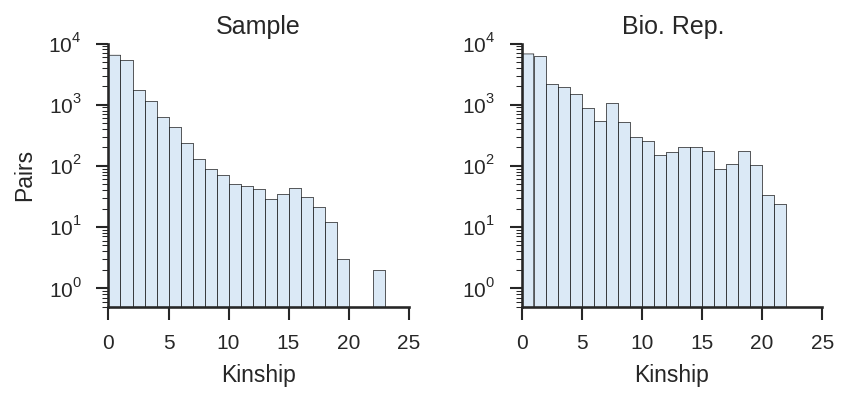

In [36]:
# Distribution of kinship values
sns.set_style("ticks")
sns.set_palette("Blues")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.kinship)
    ax.hist(x, bins=max(x))
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("Kinship")
axes[0].set_ylabel("Pairs")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_kinship", output_dir, output_suffix, output_formats, savefig_args)

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


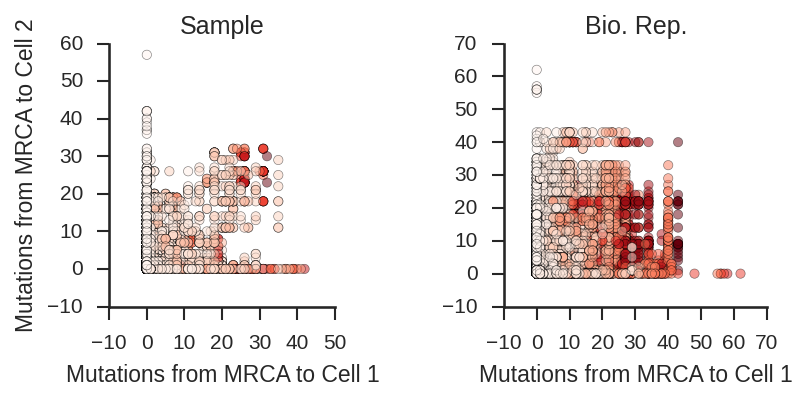

In [37]:
# Distribution of kinship values
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.dist1)
    y = list(df.dist2)
    c = list(df.kinship)
    ax.scatter(x, y, c=c, alpha=0.5, cmap=cmap)
    ax.set_aspect('equal')
    ax.set_xlabel("Mutations from MRCA to Cell 1")
axes[0].set_ylabel("Mutations from MRCA to Cell 2")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "scatter_mut_dist_1vs2", output_dir, output_suffix, output_formats, savefig_args)

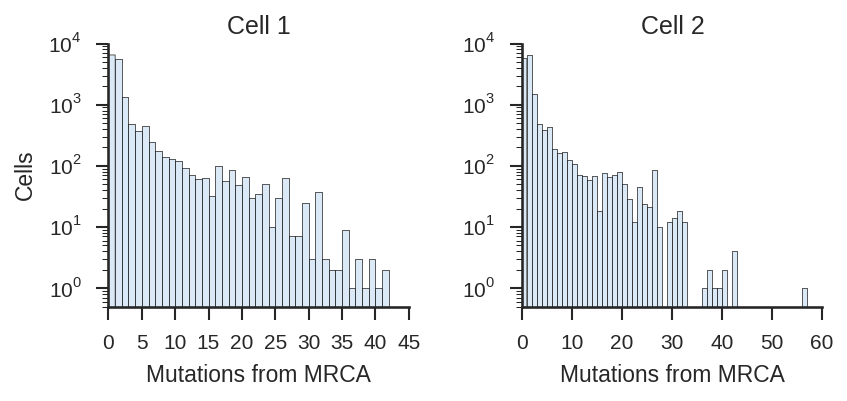

In [38]:
# Distributions of distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
ax = axes[0]
x = list(df_V1.dist1)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 1")
ax.set_xlabel("Mutations from MRCA")
ax.set_ylabel("Cells")
ax = axes[1]
x = list(df_V1.dist2)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 2")
ax.set_xlabel("Mutations from MRCA")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_mut_dist_V1", output_dir, output_suffix, output_formats, savefig_args)

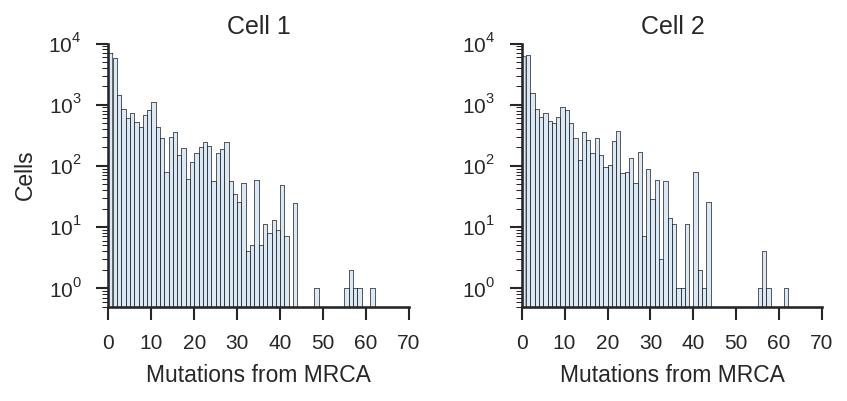

In [39]:
# Distributions of distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
ax = axes[0]
x = list(df_V3.dist1)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 1")
ax.set_xlabel("Mutations from MRCA")
ax.set_ylabel("Cells")
ax = axes[1]
x = list(df_V3.dist2)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 2")
ax.set_xlabel("Mutations from MRCA")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_mut_dist_V3", output_dir, output_suffix, output_formats, savefig_args)

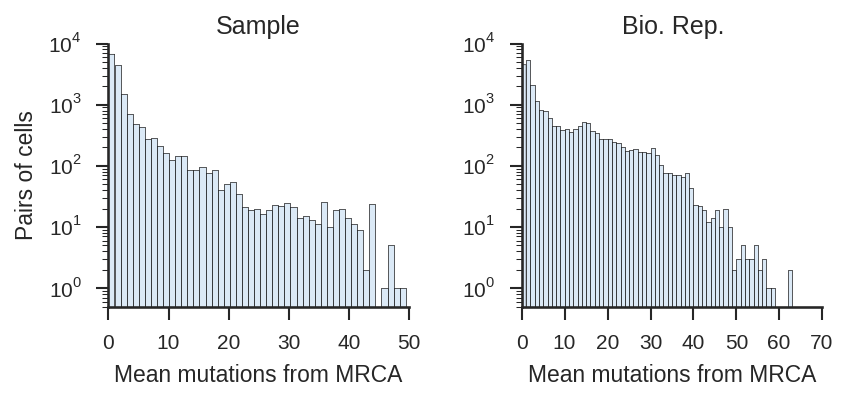

In [41]:
# Distribution of mean distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.mean_sib_dist)
    ax.hist(x, bins=int(max(x)))
    ax.set_aspect('equal')
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_xlabel("Mean mutations from MRCA")
axes[0].set_ylabel("Pairs of cells")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_mean_mut_dist", output_dir, output_suffix, output_formats, savefig_args)

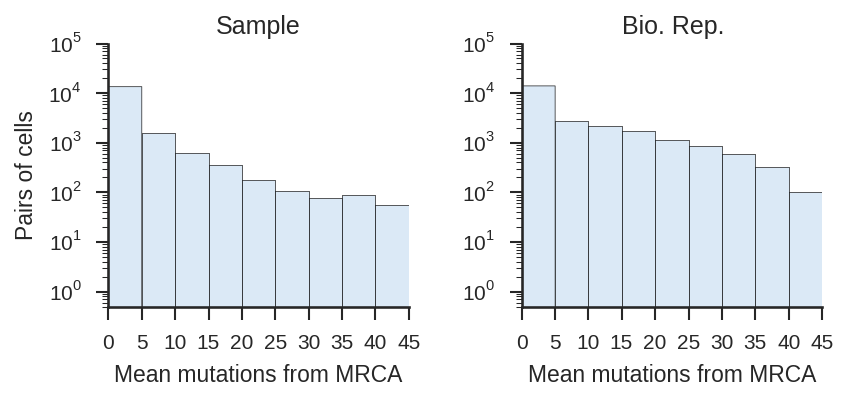

In [42]:
# Distributions of mean distance to sib1 and sib2 with bigger bins
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.mean_sib_dist)
    bins = np.arange(0, 50, 5)
    ax.hist(x, bins=bins)
    ax.set_aspect('equal')
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_xlabel("Mean mutations from MRCA")
axes[0].set_ylabel("Pairs of cells")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_mean_mut_dist_bins", output_dir, output_suffix, output_formats, savefig_args)

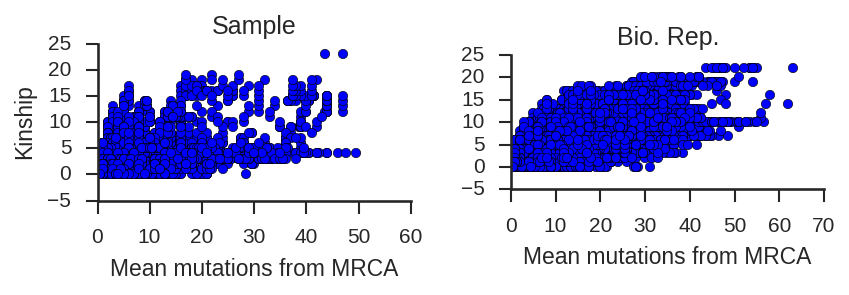

In [49]:
# Kinship versus mean mutations from MRCA
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,6))
for ax, df in zip(axes, dfs):
    ax.scatter(list(df.mean_sib_dist), list(df.kinship))
    ax.set_xlim(left=0)
    ax.set_aspect('equal')
    ax.set_xlabel("Mean mutations from MRCA")
axes[0].set_ylabel("Kinship")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "scatter_kinship_mean_mut_dist", output_dir, output_suffix, output_formats, savefig_args)

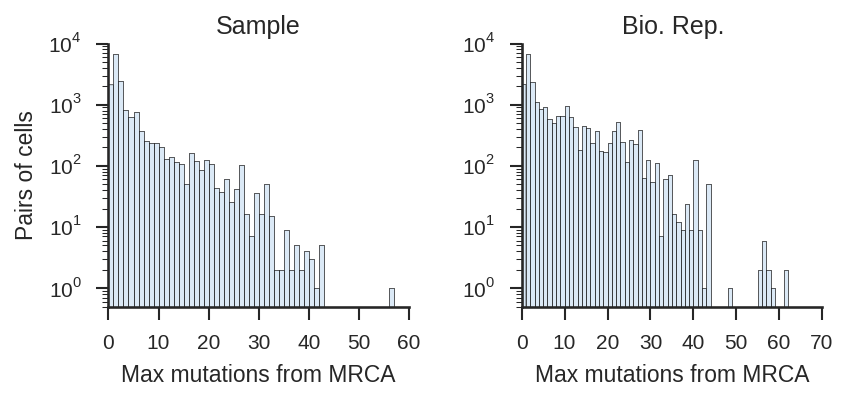

In [44]:
# Distributions of max distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.max_sib_dist)
    ax.hist(x, bins=max(x))
    ax.set_aspect('equal')
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_xlabel("Max mutations from MRCA")
axes[0].set_ylabel("Pairs of cells")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_max_mut_dist", output_dir, output_suffix, output_formats, savefig_args)

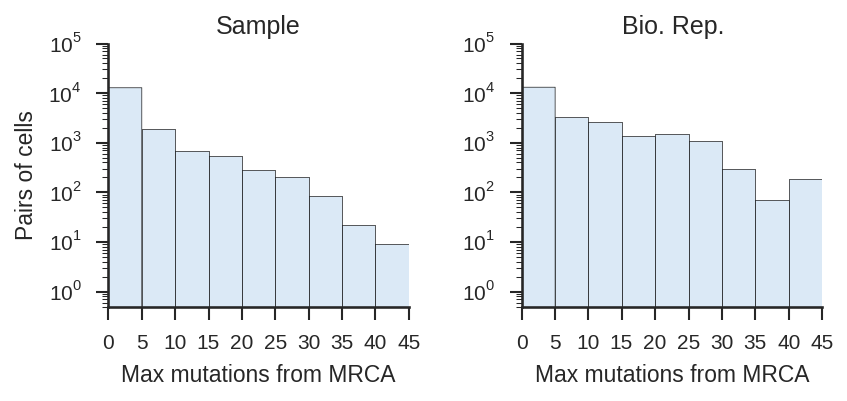

In [43]:
# Distributions of max distance to sib1 and sib2 with bigger bins
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
for ax, df in zip(axes, dfs):
    x = list(df.max_sib_dist)
    bins = np.arange(0, 50, 5)
    ax.hist(x, bins=bins)
    ax.set_aspect('equal')
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_xlabel("Max mutations from MRCA")
axes[0].set_ylabel("Pairs of cells")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_max_mut_dist_bins", output_dir, output_suffix, output_formats, savefig_args)

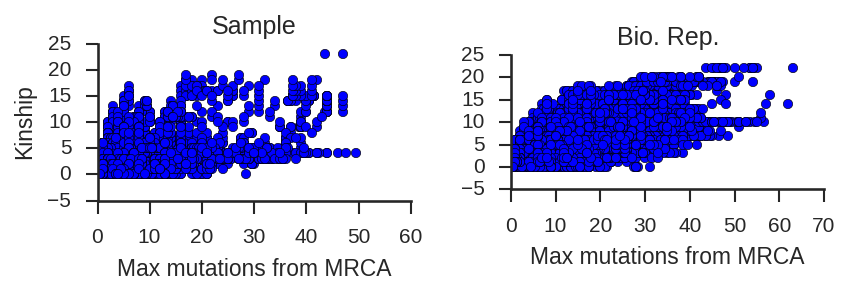

In [50]:
# Kinship versus max mutations from MRCA
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,6))
for ax, df in zip(axes, dfs):
    ax.scatter(list(df.mean_sib_dist), list(df.kinship))
    ax.set_xlim(left=0)
    ax.set_aspect('equal')
    ax.set_xlabel("Max mutations from MRCA")
axes[0].set_ylabel("Kinship")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "scatter_kinship_max_mut_dist", output_dir, output_suffix, output_formats, savefig_args)

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


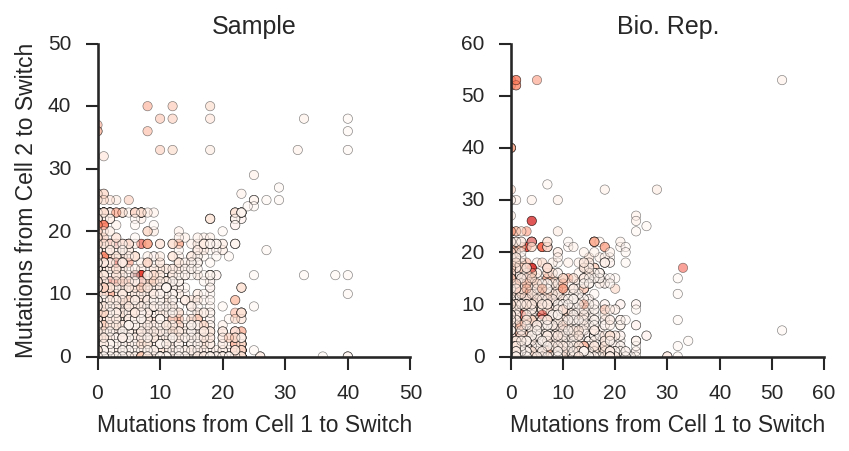

In [18]:
# Distance to switches sib1 vs sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,4))
for ax, df in zip(axes, dfs):
    ax.scatter(list(df.sib1_switch_dist), list(df.sib2_switch_dist), c=list(df.kinship), alpha=0.5, cmap=cmap)
    ax.set_xlim(left=0)
    ax.set_aspect('equal')
    ax.set_xlabel("Mutations from Cell 1 to Switch")
    ax.set_ylim(bottom=0)
axes[0].set_ylabel("Mutations from Cell 2 to Switch")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
# if savefig: save_figure(fig, "scatter_switch_dist_sib1vs2", output_dir, output_suffix, output_formats, savefig_args)

Pearson correlation
(0.24058612688131351, 2.5443631833790368e-216)

Pearson correlation
(0.24892854826896979, 0.0)



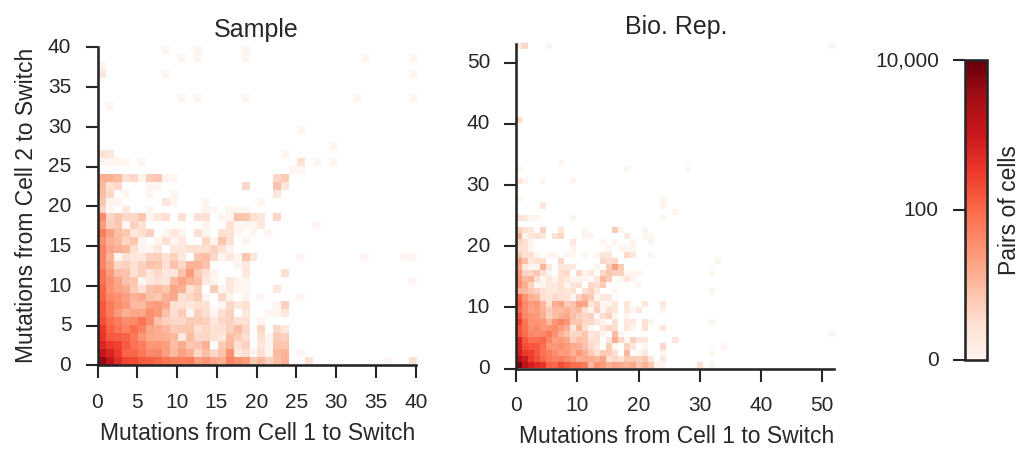

In [94]:
# Distance to switches sib1 vs sib2 as heatmap
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,4))
for ax, df in zip(axes, dfs):
    x = list(df.sib1_switch_dist)
    y = list(df.sib2_switch_dist)
    max_val = max(x + y)
    H = ax.hist2d(x, y, cmap=cmap, bins=max_val, norm=LogNorm(), vmax=10000)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_aspect('equal')
    ax.set_xlabel("Mutations from Cell 1 to Switch")
    
    print "Pearson correlation"
    print scipy.stats.pearsonr(x, y)
    print

axes[0].set_ylabel("Mutations from Cell 2 to Switch")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")

cbar_ax = fig.add_axes([1.1, 0.25, 0.025, 0.5])
cbar = fig.colorbar(H[3], cax=cbar_ax, ticks=[1, 100, 10000])
cbar.ax.set_yticklabels(['0', '100', '10,000'])
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_label("Pairs of cells")
# cbar.ax.get_yaxis().labelpad = -30

# Was unable to move ticks to other side (ugly, fuck matplotlib). Attempts:
# cbar.ax.tick_params(axis='y', direction='out')
# cbar.ax.yaxis.tick_right()
# cbar.ax.tick_params(axis='y', direction='out')

sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "heatmap_switch_dist_sib1vs2", output_dir, output_suffix, output_formats, savefig_args)

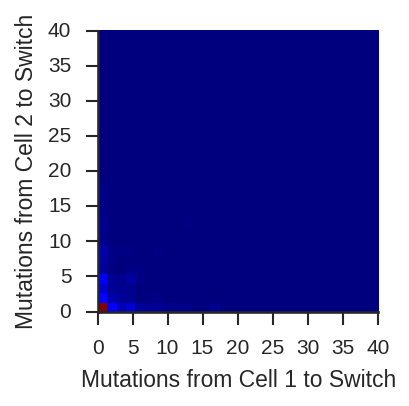

In [24]:
# Distance to switches sib1 vs sib2 as heatmap
sns.set_style("ticks")
cmap = plt.get_cmap("jet")
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.hist2d(list(df_V1.sib1_switch_dist), list(df_V1.sib2_switch_dist), bins=30, cmap=cmap)
ax.set_aspect('equal')
ax.set_xlabel("Mutations from Cell 1 to Switch")
ax.set_ylabel("Mutations from Cell 2 to Switch")
sns.despine()
plt.tight_layout()

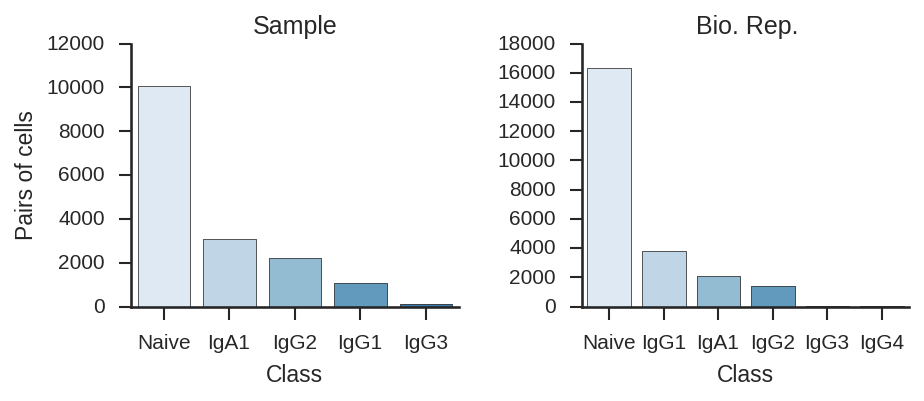

In [56]:
# Distribution of origin isotypes
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6.5,3))
for ax, df in zip(axes, dfs):
    x = df.mrca_isotype.value_counts(normalize=False)
    sns.barplot(ax=ax, y=x, x=x.index)
    # ax.set_aspect('equal')
    ax.set_xlabel("Class")
    ax.set_ylabel("")
axes[0].set_ylabel("Pairs of cells")
axes[0].set_title("Sample")
axes[1].set_title("Bio. Rep.")
sns.despine()
plt.tight_layout()
if savefig: save_figure(fig, "hist_sibs_origin_isotypes", output_dir, output_suffix, output_formats, savefig_args)

# Bin cells by mutational distance from MRCA

In [9]:
def bin_by_mut_dist(df, bins):
    df["mean_sib_dist_bin"] = np.digitize(df.mean_sib_dist, bins)
    df["max_sib_dist_bin"] = np.digitize(df.max_sib_dist, bins)
    return df

In [10]:
bins = np.arange(0, 50, 2)
df_V1 = bin_by_mut_dist(df_V1, bins)
df_V3 = bin_by_mut_dist(df_V3, bins)

# Shuffle switch isotypes for comparison

In [11]:
def shuffle(df):
    
    df_shuffled = df.copy()
    
    for isotype in df["mrca_isotype"].unique():
        
        isotype_shuffled = np.random.permutation(np.array(df[df.mrca_isotype == isotype].sib2_switch_isotype.tolist())).tolist()
        df_shuffled.loc[df[df.mrca_isotype == isotype].index,"sib2_switch_isotype"] = isotype_shuffled

    return df_shuffled

In [12]:
df_V1_shuffled = shuffle(df_V1)
df_V3_shuffled = shuffle(df_V3)

# Plot conditional probability of switch fate given Cell 2 fate

In [61]:
def plot_cond_probs_by_bins(df, bin_by="max_sib_dist_bin", vmax=len(bins)):
    """ Plot all conditional probabilities """
    
    isotypes_to_skip = ["IgE", "IgG4", "IgG3"]

    isotype_to_row_num = {"IgG1": 0, "IgA1": 1, "IgG2": 2, "IgA2": 3}
    isotype_to_col_num = {"Naive": 0, "IgG1": 1, "IgA1": 2, "IgG2": 3}
    
    cmap = matplotlib.cm.coolwarm_r
    vmin = 1
    vmax = vmax
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    sns.set_style("darkgrid")

    fig, axes = plt.subplots(len(isotype_to_row_num.keys()), len(isotype_to_col_num.keys()), figsize=(8, 8), sharex=True, sharey=True)

    # Hide all axes by default
    for a1 in axes:
        for a2 in a1:
            a2.axis('off')

    for isotype, group in df.groupby('mrca_isotype'):

        if isotype in isotypes_to_skip: continue

        col = isotype_to_col_num[isotype]

        for sib1_switch_isotype, group2 in group.groupby('sib1_switch_isotype'):

            if sib1_switch_isotype in isotypes_to_skip: continue

            row = isotype_to_row_num[sib1_switch_isotype]
            ax = axes[row,col]

            row_label = "P(Relative 2 to X | \n Relative 1 to " + sib1_switch_isotype + ")"

            for myBin, group3 in group2.groupby(bin_by):
                
                if myBin > vmax: continue

                my_probs = group3['sib2_switch_isotype'].value_counts(normalize=True)

                x = [isotype_to_uid[i] for i in my_probs.index]
                y = my_probs
                color = [myBin] * len(x)

                ax.scatter(x, y, c=color, cmap=cmap, vmin=vmin, vmax=vmax)

            ax.axis('on')

            ax.set_xlim([0, len(isotype_names)])
            ax.set_ylim([-0.1, 1.1])

            ax.tick_params(axis='x', which='both', top='off')
            ax.tick_params(axis='y', which='both', right='off')

            if col == 0: ax.set_ylabel(row_label)

            if row == len(isotype_to_row_num.keys()) - 1:
                ax.set_xticks(range(1, len(isotype_names)), minor=True)
                ax.set_xticklabels(isotype_names[1:], rotation=90, minor=True)
                ax.set_xticklabels([], minor=False)
            else:
                ax.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
                pass

            if row == col:
                ax.set_title("Relatives were " + isotype.replace("Naive", "IgM/IgD"), y=1.1)

            # Label showing number of pairs
            N_string = "N = " + str(group2.shape[0])
            ax.text(0.5, 1.1, N_string, fontsize=12, zorder=10)
        
    plt.tight_layout(pad=0.01, h_pad=0) # must be called before colorbar
    
    # colorbar
    ax = axes[1,3]
    
    a = np.array([[vmin,vmax]])
    img = ax.imshow(a, cmap=cmap, norm=norm)
    ax.axis('on')
    ax.set_visible(False)
    
    cax = plt.axes([0.8, 0.55, 0.05, 0.2])
    cb = plt.colorbar(img, cax=cax)
    cb.ax.invert_yaxis()
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.set_label("Kinship")
    
    return fig, axes

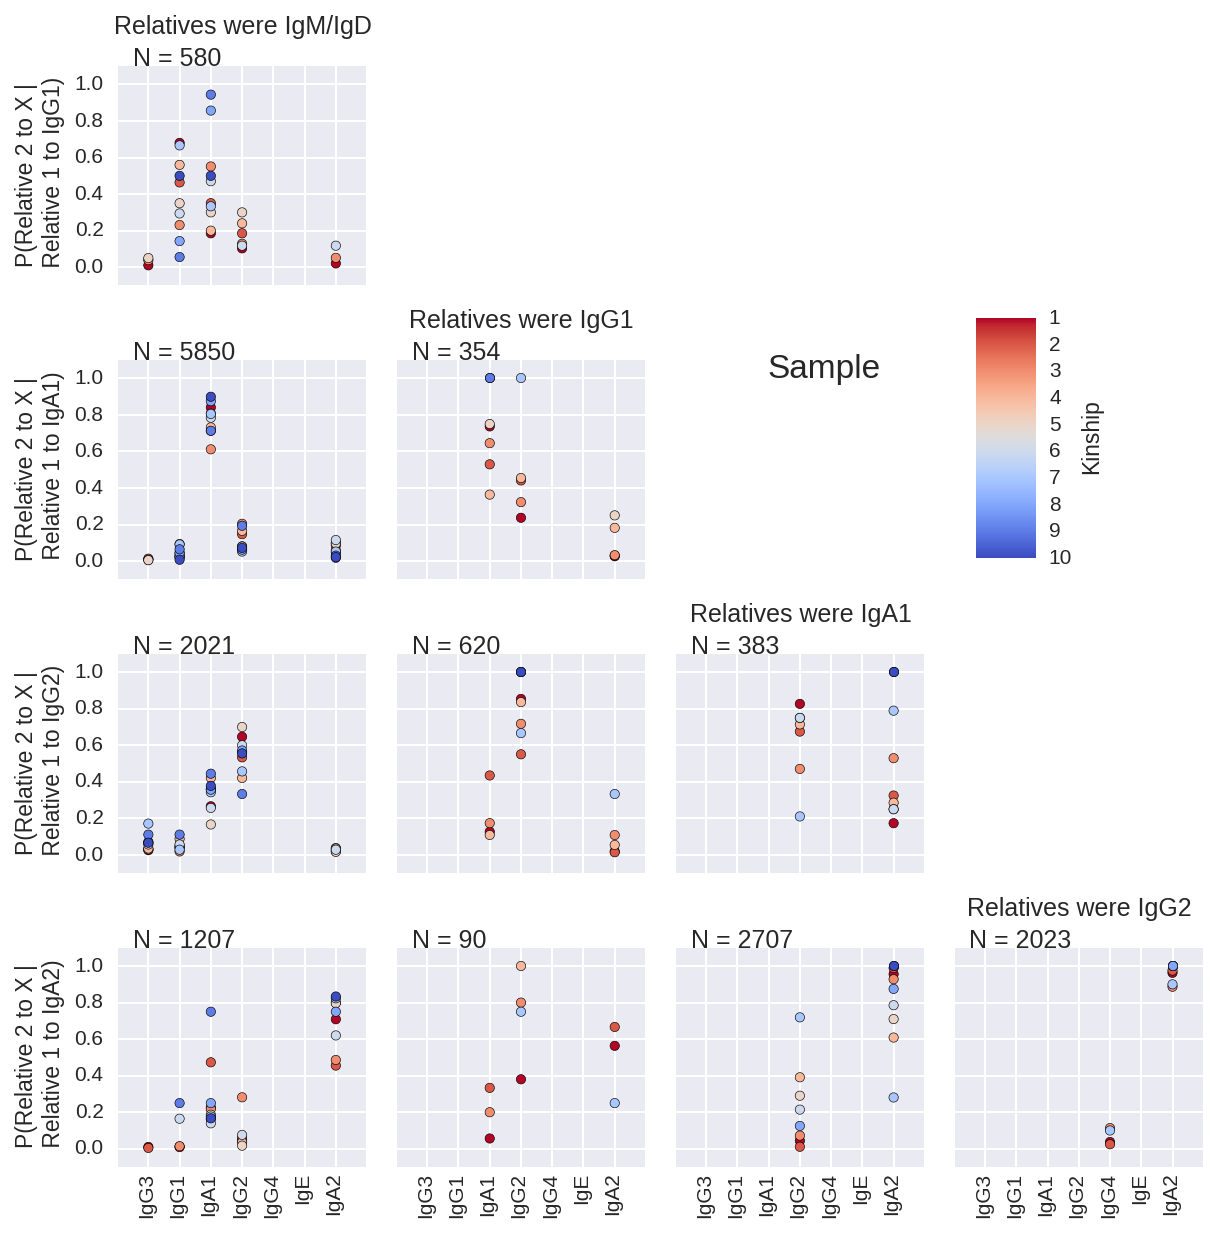

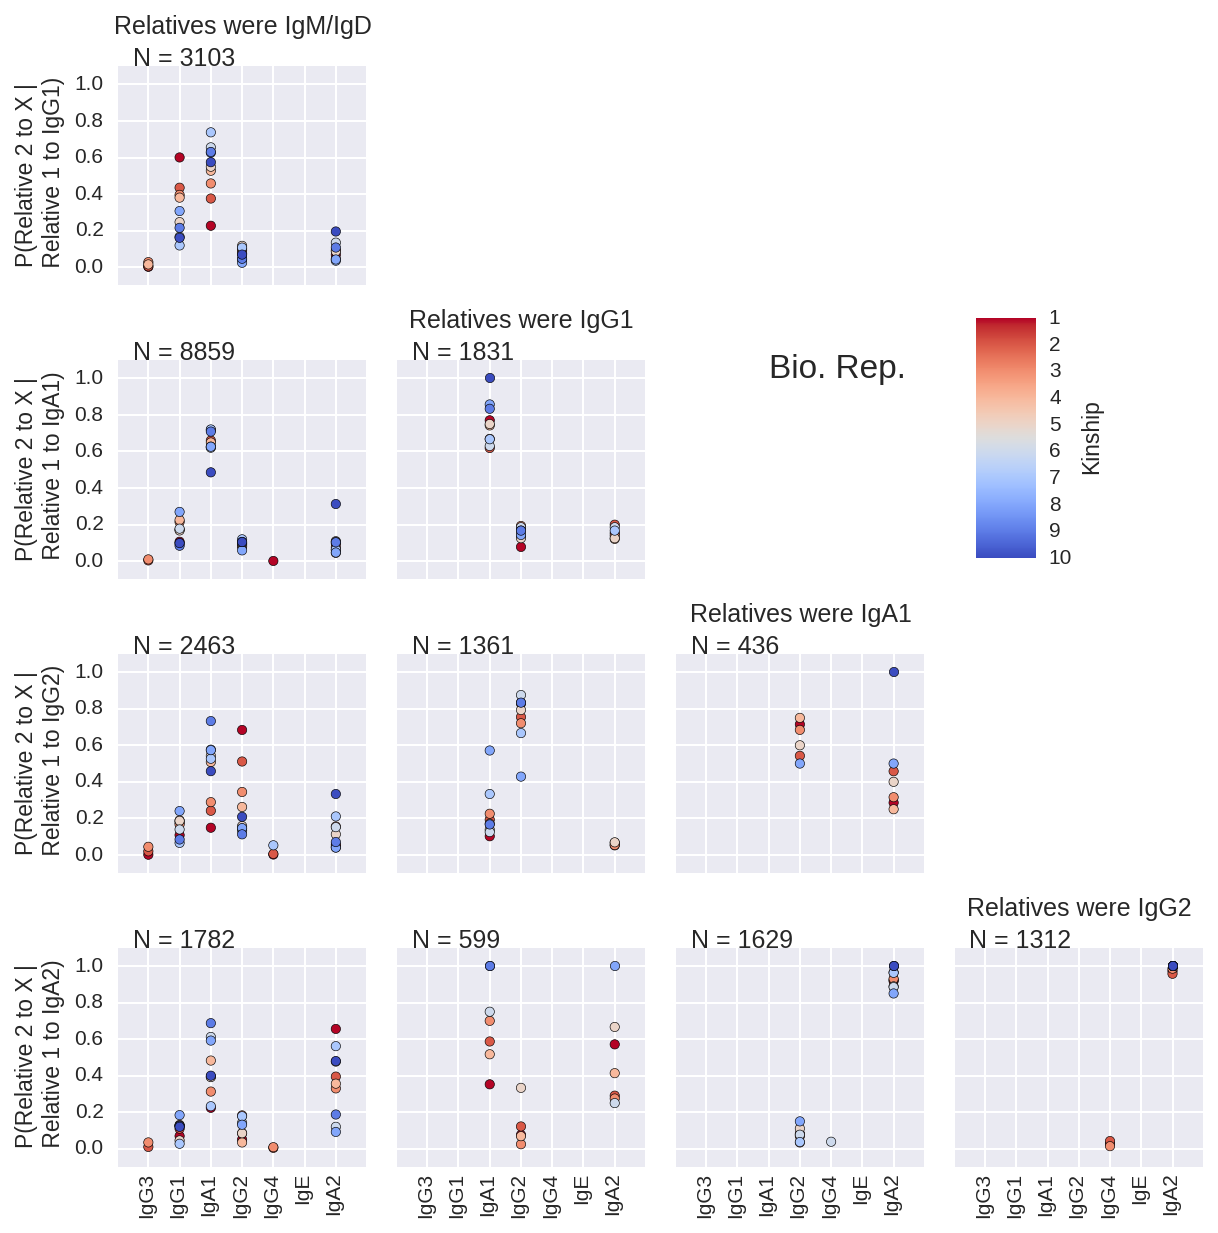

In [62]:
# Bin by max mutational distance
fig, axes = plot_cond_probs_by_bins(df_V1, "max_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Sample", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_max_sib_dist_bin_V1", output_dir, output_suffix, output_formats, savefig_args)

fig, axes = plot_cond_probs_by_bins(df_V3, "max_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Bio. Rep.", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_max_sib_dist_bin_V3", output_dir, output_suffix, output_formats, savefig_args)

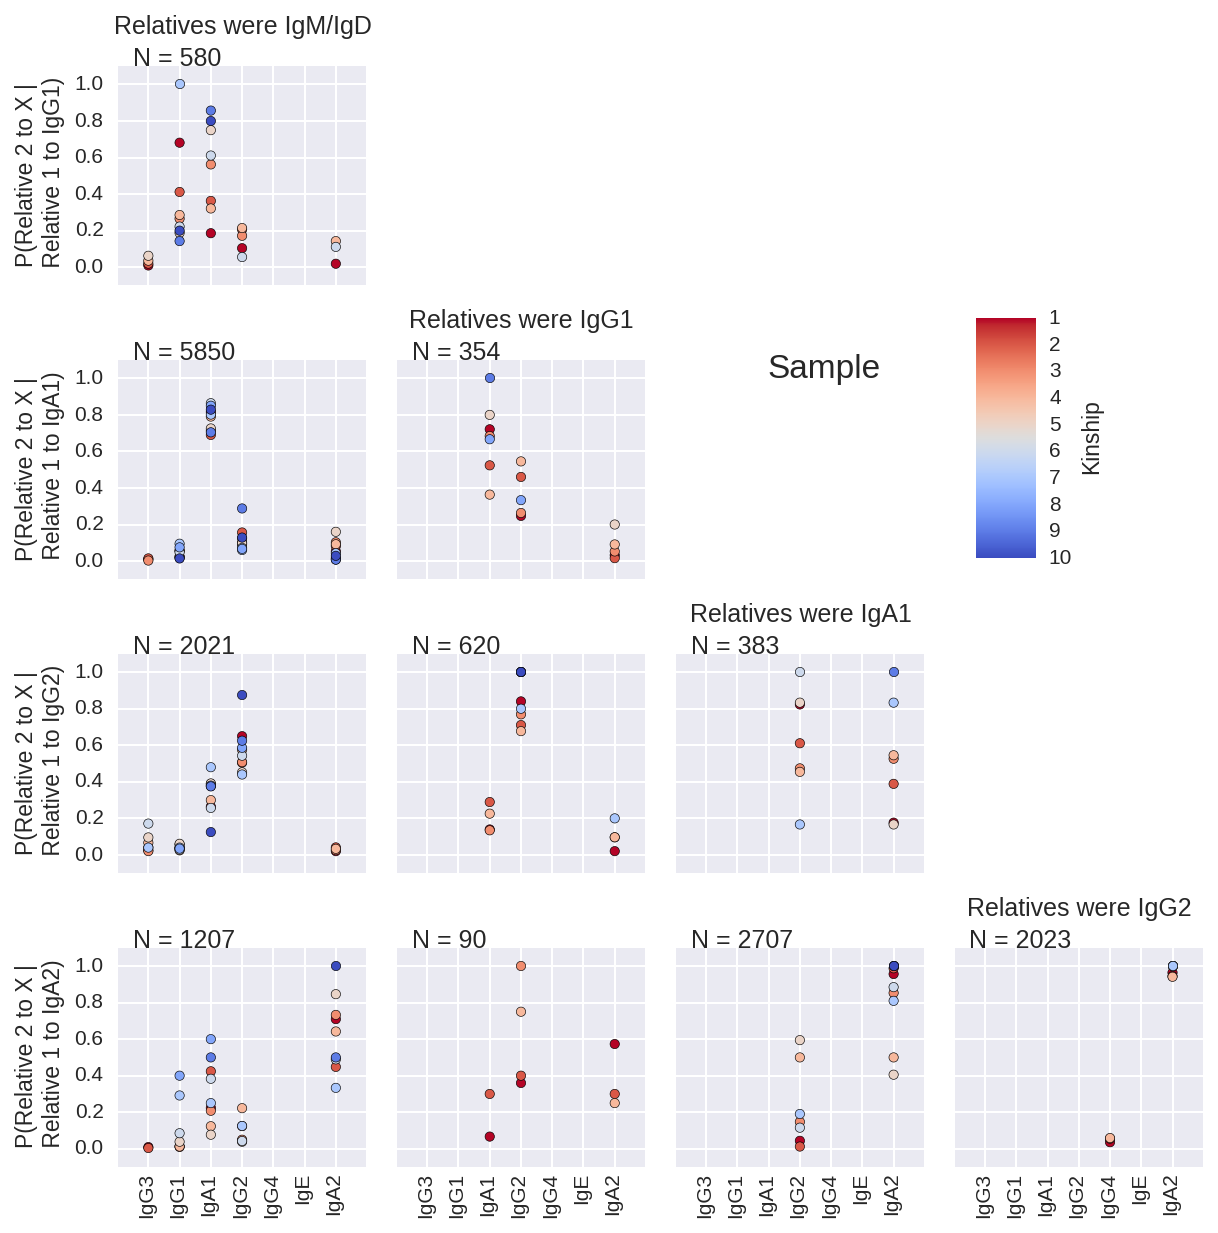

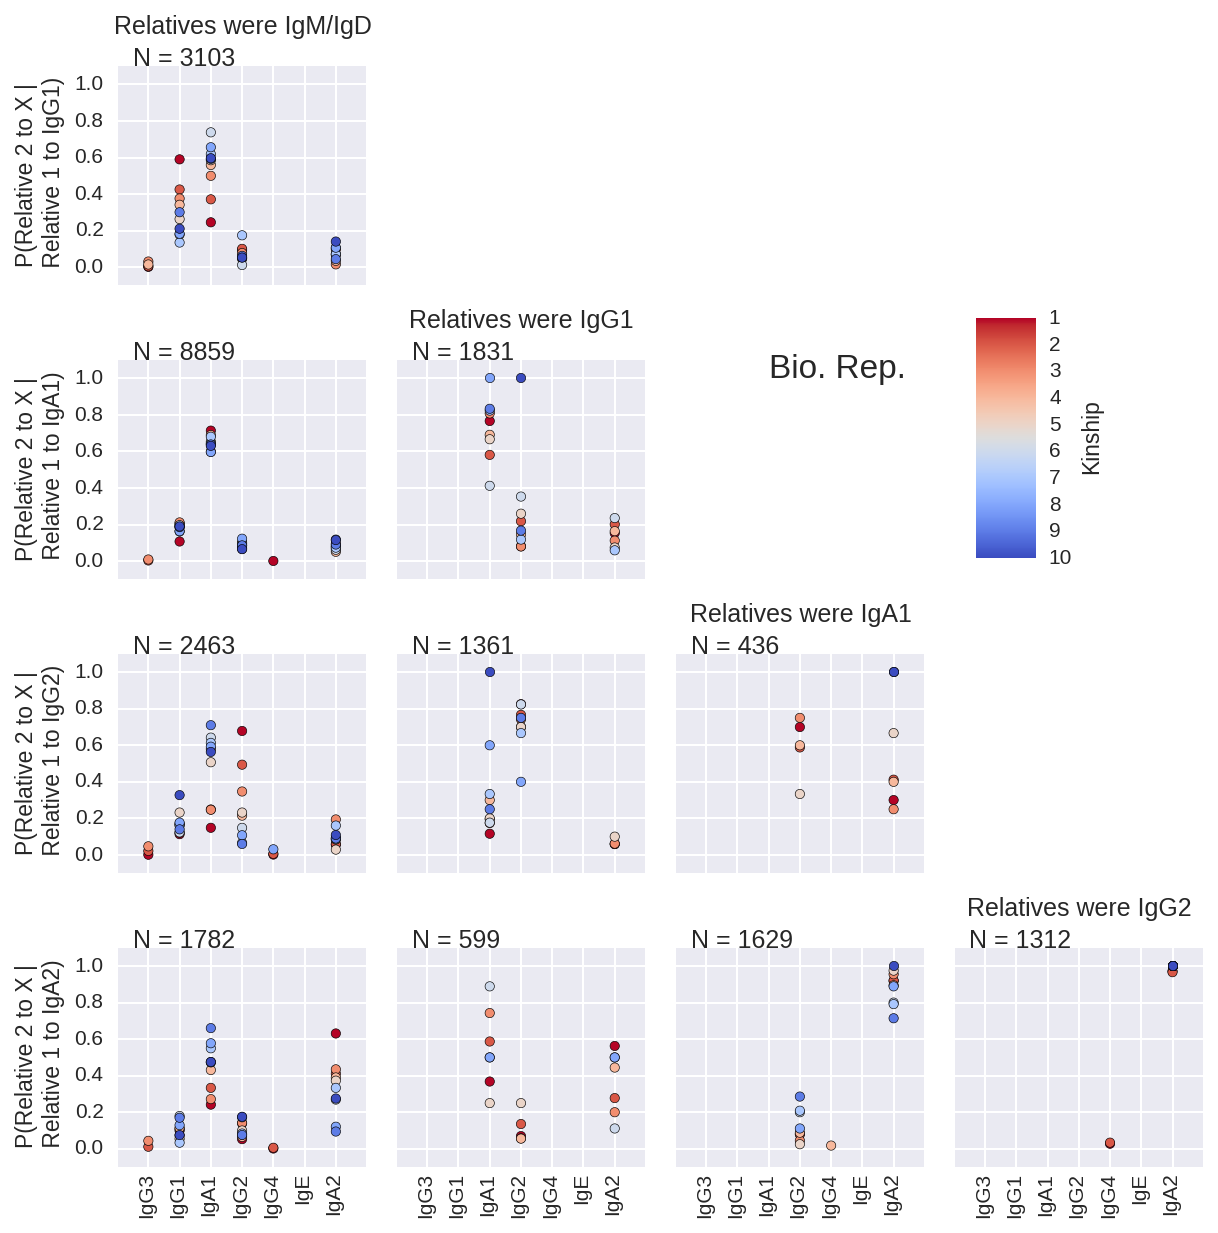

In [63]:
# Bin by mean mutational distance
fig, axes = plot_cond_probs_by_bins(df_V1, "mean_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Sample", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_mean_sib_dist_bin_V1", output_dir, output_suffix, output_formats, savefig_args)

fig, axes = plot_cond_probs_by_bins(df_V3, "mean_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Bio. Rep.", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_mean_sib_dist_bin_V3", output_dir, output_suffix, output_formats, savefig_args)

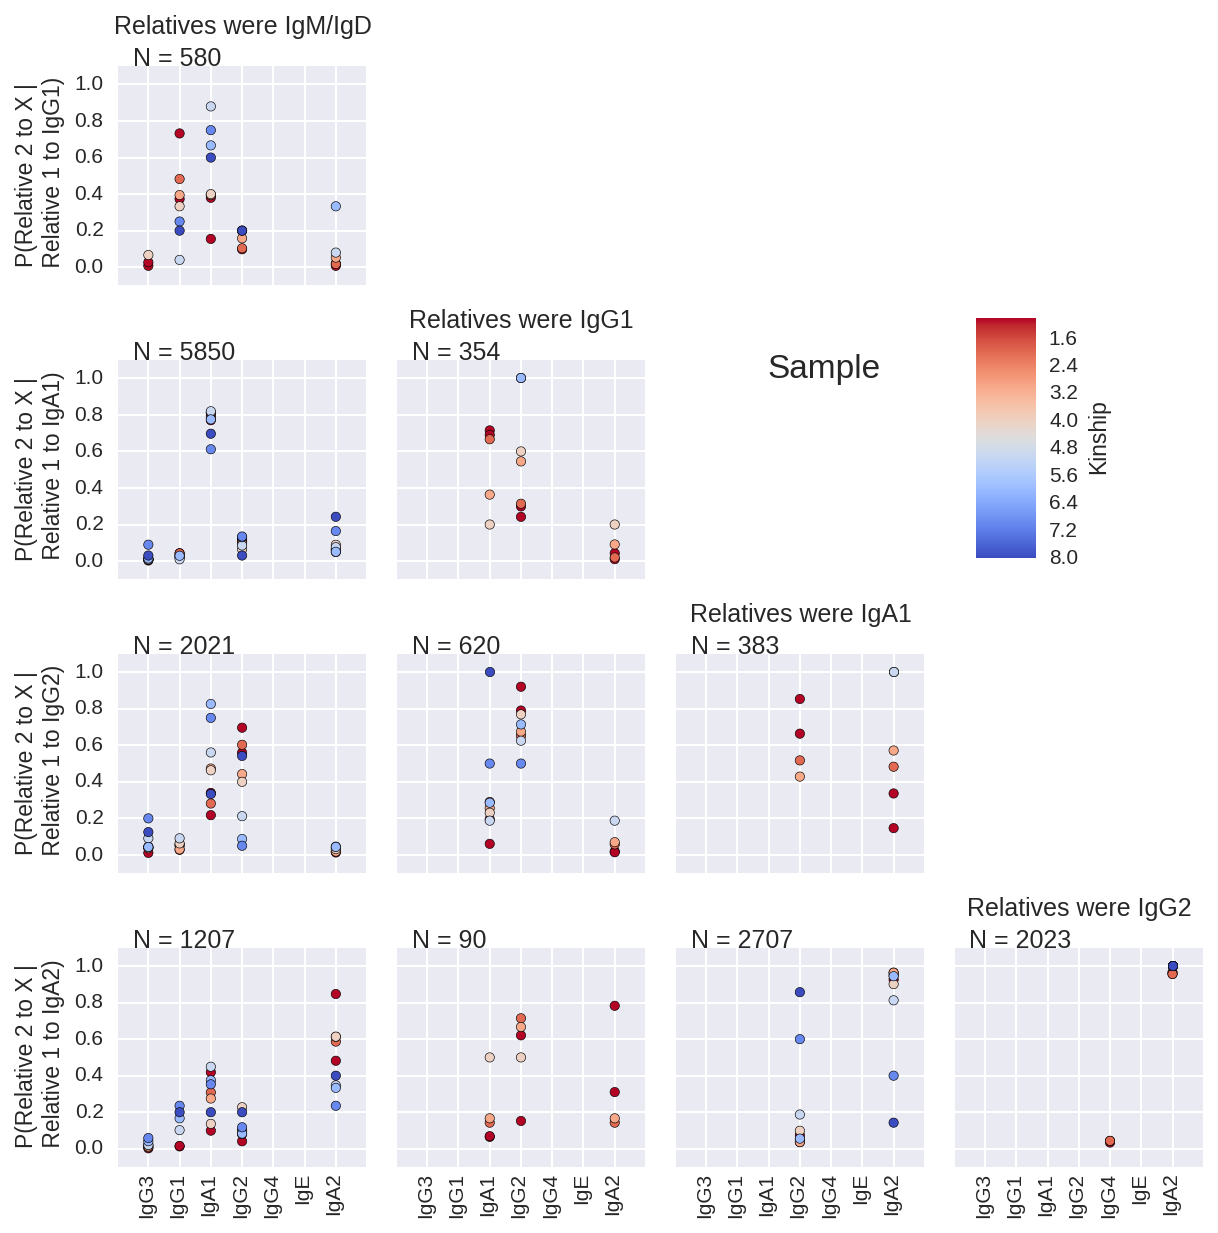

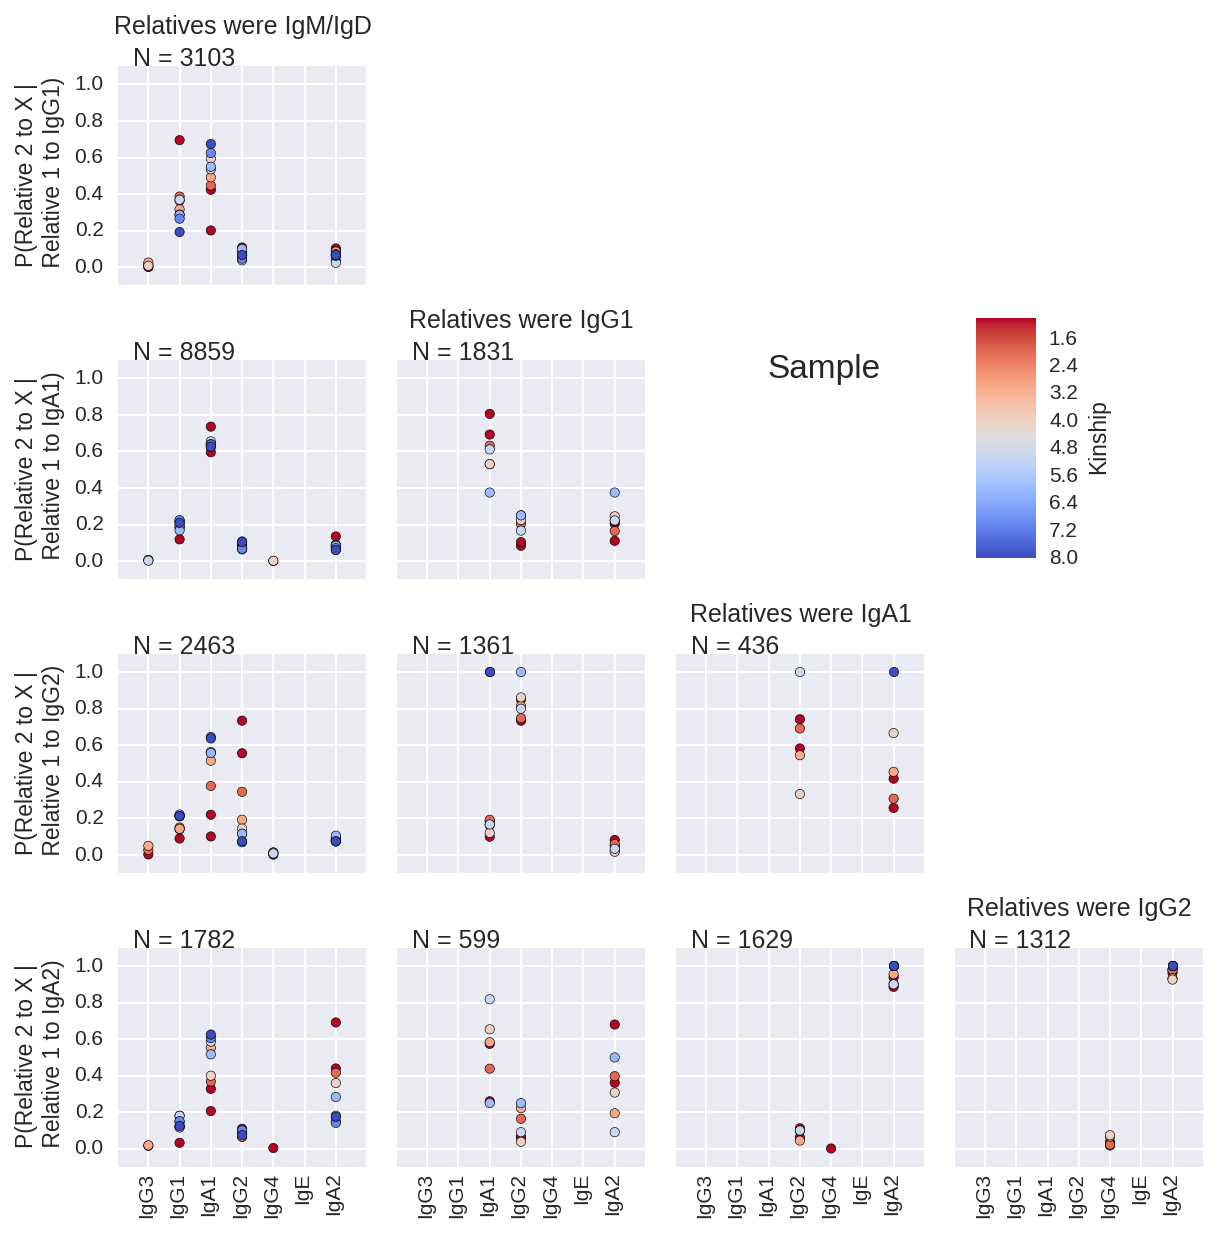

In [64]:
# Bin by kinship
fig, axes = plot_cond_probs_by_bins(df_V1, "kinship", 8)
axes[1,2].text(3, 1, "Sample", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_kinship_V1", output_dir, output_suffix, output_formats, savefig_args)

fig, axes = plot_cond_probs_by_bins(df_V3, "kinship", 8)
axes[1,2].text(3, 1, "Sample", size=16)
if savefig: save_figure(fig, "sib_cond_probs_by_kinship_V3", output_dir, output_suffix, output_formats, savefig_args)

# Show concordance using Yule's Q

In [13]:
def yules_Q(a, b, c, d):
    OR = (float(a) * float(d)) / (float(b) * float(c))
    Q = (OR - 1) / (OR + 1)
    return Q

def calc_Q(df, bin_by):
    
    start_time = time.time()
    
    df_Q = pd.DataFrame(columns=["isotype", "destination_isotype", bin_by, "Q", "num_cases", "a", "b", "c", "d"])

    i = 0

    for isotype, group in df.groupby('mrca_isotype'):

        for myBin, group2 in group.groupby(bin_by):

            possible_switch_destinations = list(set(list(group2.sib1_switch_isotype.unique()) + list(group2.sib2_switch_isotype.unique())))
            
            for dest in possible_switch_destinations:

                num_cases = group2.shape[0]

                a = sum((group2.sib1_switch_isotype == dest) & (group2.sib2_switch_isotype == dest))
                b = sum((group2.sib1_switch_isotype == dest) & (group2.sib2_switch_isotype != dest))
                c = sum((group2.sib1_switch_isotype != dest) & (group2.sib2_switch_isotype == dest))
                d = sum((group2.sib1_switch_isotype != dest) & (group2.sib2_switch_isotype != dest))

                min_count_cutoff = 1
                if (a != 0 and b != 0 and c != 0 and d != 0) and (a >= min_count_cutoff and b >= min_count_cutoff and c >= min_count_cutoff and d >= min_count_cutoff):
                    Q = yules_Q(a, b, c, d)
                    df_Q.loc[i] = [isotype, dest, myBin, Q, num_cases, a, b, c, d]
                    i += 1
                else:
                    # Q is not defined
                    # print "Q not defined", kinship, isotype, dest, a, b, c, d
                    Q = np.nan
    
#    print "Elapsed time (wall clock):", time.time() - start_time
    return df_Q

def get_df_Qs(df):
    df_Q_kinship = calc_Q(df, bin_by="kinship")
    df_Q_max_sib_dist_bin = calc_Q(df, bin_by="max_sib_dist_bin")
    df_Q_mean_sib_dist_bin = calc_Q(df, bin_by="mean_sib_dist_bin")
    return df_Q_kinship, df_Q_max_sib_dist_bin, df_Q_mean_sib_dist_bin

In [14]:
# Calculate Q for datasets
_, df_Q_max_sib_dist_bin_V1, _ = get_df_Qs(df_V1)
_, df_Q_max_sib_dist_bin_V3, _ = get_df_Qs(df_V3)

_, df_Q_max_sib_dist_bin_V1_shuffled, _ = get_df_Qs(df_V1_shuffled)
_, df_Q_max_sib_dist_bin_V3_shuffled, _ = get_df_Qs(df_V3_shuffled)

# Repeated shuffles to get confidence intervals on Q

In [32]:
N = 1000 # number of replicates (20 takes 50-70 seconds)

In [33]:
def shuffles(df, N, bin_by):
    
    start_time = time.time()
    
    df_Q_shuffleds = []
    
    for _ in xrange(N):
        df_shuffled = shuffle(df)
        df_Q_shuffled = calc_Q(df_shuffled, bin_by)
        df_Q_shuffleds.append(df_Q_shuffled.copy(deep=True))
        
    print "Elapsed time (wall clock):", time.time() - start_time
    
    return df_Q_shuffleds

In [98]:
df_Q_max_sib_dist_bin_V1_shuffleds = shuffles(df_V1, N, "max_sib_dist_bin")

Elapsed time (wall clock): 2429.01864409


In [103]:
df_Q_max_sib_dist_bin_V3_shuffleds = shuffles(df_V3, N, "max_sib_dist_bin")

Elapsed time (wall clock): 3272.52433395


In [104]:
len(df_Q_max_sib_dist_bin_V1_shuffleds)

1000

# Plot Yule's Q against mutational distance

In [466]:
def plot_Q_by_bin_all(df_Q, df_Q_shuffleds, bin_by):
    
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    isotypes_to_skip_for_Q = isotypes_to_skip

    isotype_to_row_num = {"IgG1": 0, "IgA1": 1, "IgG2": 2, "IgA2": 3}
    isotype_to_col_num = {"Naive": 0, "IgG1": 1, "IgA1": 2, "IgG2": 3}

    fig, axes = plt.subplots(len(set(df_Q.destination_isotype.unique()) - set(isotypes_to_skip)), len(set(df_Q.isotype.unique()) - set(isotypes_to_skip_for_Q)), figsize=(8, 8), sharex=True, sharey=True)

    # Hide all axes by default
    for a1 in axes:
        for a2 in a1:
            a2.axis('off')

    for isotype, group in df_Q.groupby('isotype'):

        if isotype in isotypes_to_skip_for_Q: continue
        col = isotype_to_col_num[isotype]

        for destination_isotype, group2 in group.groupby('destination_isotype'):

            if destination_isotype in isotypes_to_skip: continue

            row = isotype_to_row_num[destination_isotype]
            ax = axes[row,col]

            # Plot
            x = group2[bin_by]
            y = group2.Q
            ax.plot(x, y, c='red', marker='o', linewidth=2)

            # Turn on axis
            ax.axis('on')

            # Titles
            if row == col:
                ax.set_title("Relatives were " + isotype.replace("Naive", "IgM/IgD"), y=1.1)
                
            # Switch to label
            switch_string = "Switch to " + destination_isotype
            ax.text(1, 1.05, switch_string, fontsize=12, zorder=10)
            
            # Plot shuffled traces
            for df_Q_shuff in df_Q_shuffleds:
                my_df_shuff = df_Q_shuff[(df_Q_shuff.isotype == isotype) & (df_Q_shuff.destination_isotype == destination_isotype)]
                x = my_df_shuff[bin_by]
                y = my_df_shuff.Q
                color = "#666666"
                ax.plot(x, y, c=color, alpha=0.2, linewidth=0.5, zorder=1)

    for row, ax_row in enumerate(axes):
        for col, ax in enumerate(ax_row):
            # ax.set_xlim([1, 10])
            ax.set_ylim([-1, 1])
            ax.tick_params(axis='x', which='both', top='off')
            ax.tick_params(axis='y', which='both', right='off')
            ax.set_xticklabels([0, 10, 20, 30, 40, 50])
            if col > 0: ax.tick_params(axis='y', which='both', left='off')
            if row != len(axes)-1: ax.tick_params(axis='x', which='both', bottom='off')

    for ax_row in axes:
        ax_row[0].set_ylabel("Yule's Q")

    plt.tight_layout(pad=0.1, h_pad=0.3)
    
    return fig, axes

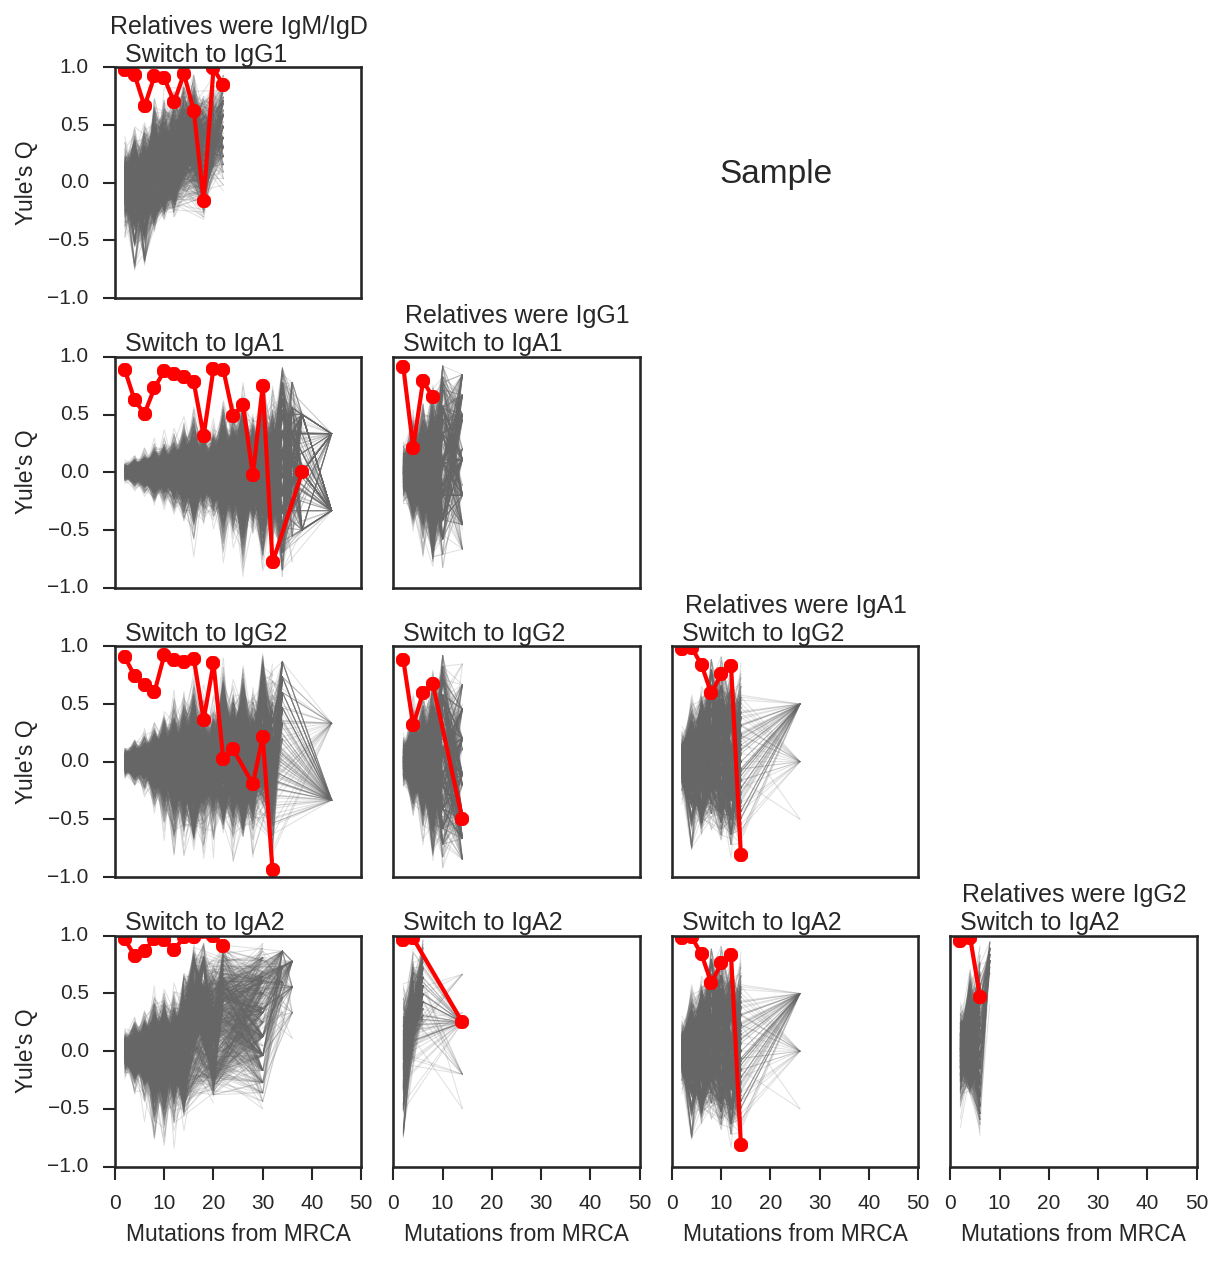

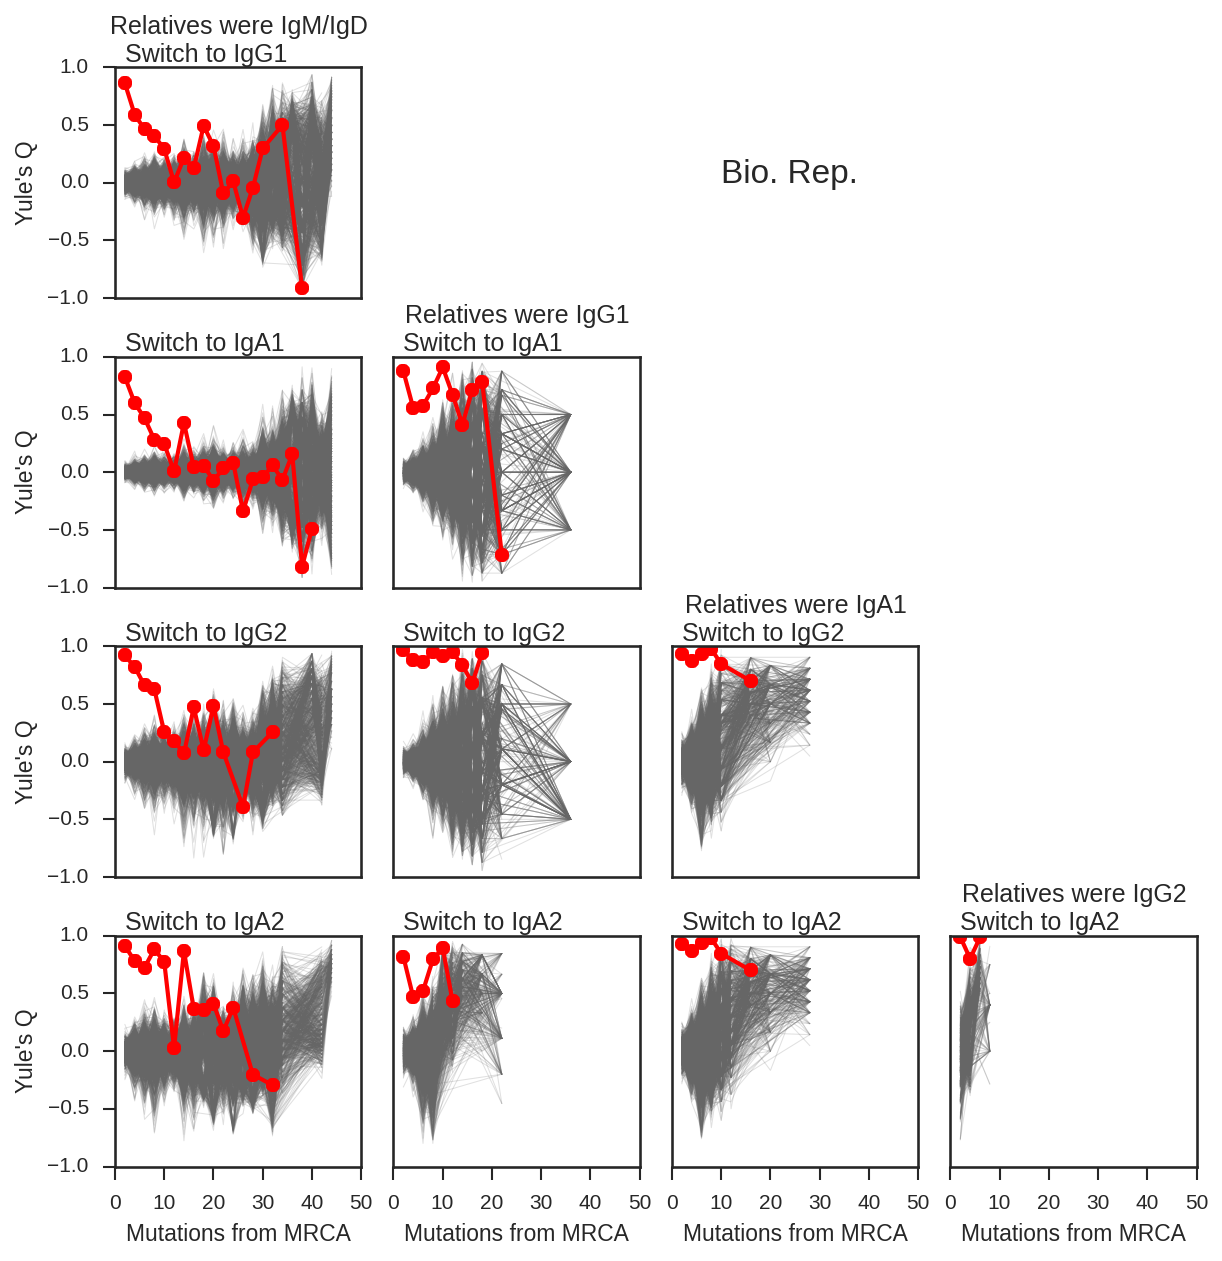

In [467]:
fig, axes = plot_Q_by_bin_all(df_Q_max_sib_dist_bin_V1, df_Q_max_sib_dist_bin_V1_shuffleds, bin_by="max_sib_dist_bin")
for ax in axes[-1]:
    ax.set_xlabel("Mutations from MRCA")
axes[0,2].text(5, 0, "Sample", ha="left", size=16)
if savefig: save_figure(fig, "sib_yules_Q_subplots_V1", output_dir, output_suffix, output_formats, savefig_args)
    
fig, axes = plot_Q_by_bin_all(df_Q_max_sib_dist_bin_V3, df_Q_max_sib_dist_bin_V3_shuffleds, bin_by="max_sib_dist_bin")
for ax in axes[-1]:
    ax.set_xlabel("Mutations from MRCA")
axes[0,2].text(5, 0, "Bio. Rep.", ha="left", size=16)
if savefig: save_figure(fig, "sib_yules_Q_subplots_V3", output_dir, output_suffix, output_formats, savefig_args)

In [38]:
# Plot for only Naive cells with pretty format

def plot_Q_by_bin_oneIsotype(df_Qs, df_Q_shuffledss, from_isotype, bin_by):
    
    to_isotypes = ["IgG1", "IgA1", "IgG2", "IgA2"]
    isotype_to_col_num = dict(zip(to_isotypes, range(len(to_isotypes))))
    
    sns.set_style("ticks")
    
    fig, axes = plt.subplots(2, 4, figsize=(8,4), sharex=True, sharey=True)
    
    for to_isotype in to_isotypes:
        
        col_num = isotype_to_col_num[to_isotype]
        
        rows = [0, 1]
        for i in rows:
            
            ax = axes[i, col_num]
            df_Q = df_Qs[i]
            df_Q_shuffleds = df_Q_shuffledss[i]

            myData = df_Q[df_Q["isotype"] == from_isotype][df_Q["destination_isotype"] == to_isotype]
            x = myData[bin_by]
            y = myData.Q
            ax.plot(x, y, c='red', marker='o', linewidth=1, label="Data")

            for df_Q_shuff in df_Q_shuffleds:
                my_df_shuff = df_Q_shuff[(df_Q_shuff.isotype == from_isotype) & (df_Q_shuff.destination_isotype == to_isotype)]
                x = my_df_shuff[bin_by]
                y = my_df_shuff.Q
                color = "#666666"
                ax.plot(x, y, c=color, alpha=0.2, linewidth=0.5, zorder=1, label="")
                
            ax.plot([], [], c=color, alpha=1.0, linewidth=0.5, label="Shuffled")
    
    for i, ax_row in enumerate(axes):
        for ax in ax_row:
            sns.despine()
            xticks = ax.get_xticks()
            ax.set_xlim(xticks[0]-0.1,xticks[-1]+0.1)
            ax.set_xticks(xticks)
            yticks = ax.get_yticks()
            ax.set_ylim(yticks[0]-0.1,yticks[-1]+0.1)
            ax.set_yticks(yticks)
            ax.set_xticklabels([0, 10, 20, 30, 40, 50])
    
    for ax, to_isotype in zip(axes[0], to_isotypes):
        ax.set_title(from_isotype.replace("Naive", "IgM/IgD") + " -> " + to_isotype)
    
    fig.text(0.5, -0.02, "Mutations from MRCA", ha='center', size=12)
    fig.text(-0.015, 0.5, "Yule's Q", va='center', rotation='vertical', size=12)

    axes[-1, -1].legend(bbox_to_anchor = (1.15, 0.4, 1, 1), prop={'size':12})
    
    plt.tight_layout()
    
    return fig, axes

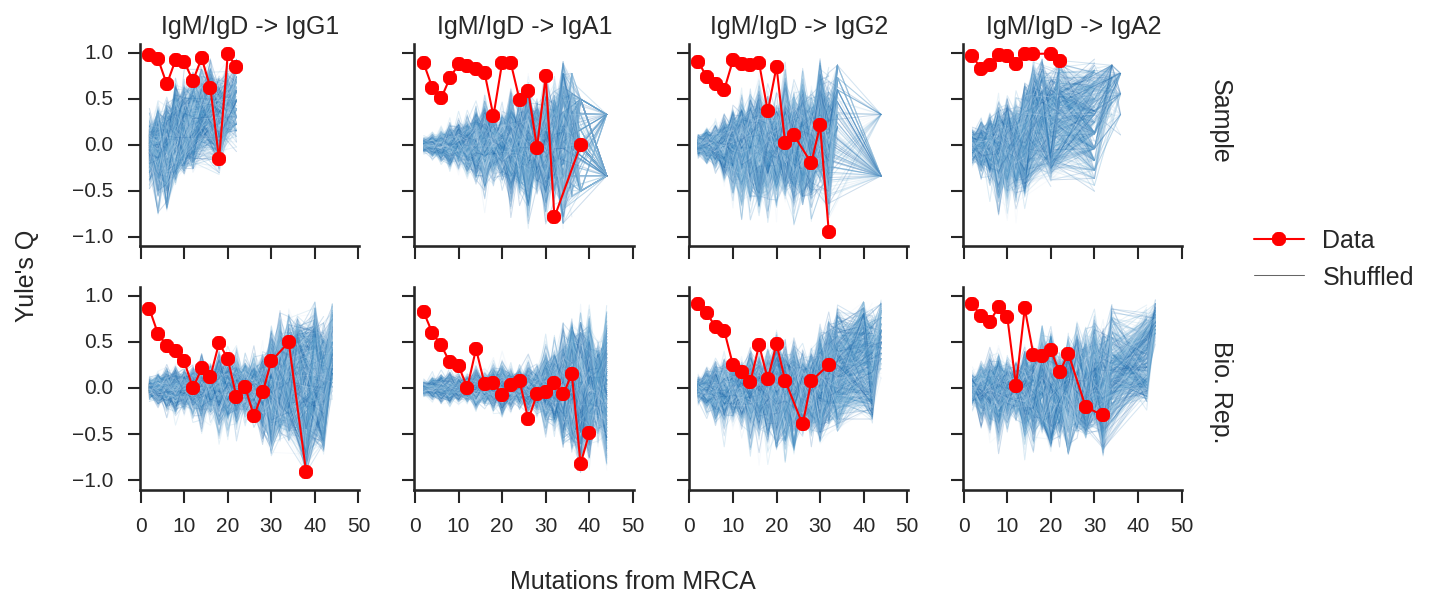

In [140]:
fig, axes = plot_Q_by_bin_oneIsotype([df_Q_max_sib_dist_bin_V1, df_Q_max_sib_dist_bin_V3],
                                     [df_Q_max_sib_dist_bin_V1_shuffleds, df_Q_max_sib_dist_bin_V3_shuffleds],
                                     from_isotype="Naive", bin_by="max_sib_dist_bin")

fig.text(0.98, 0.76, "Sample", va='center', rotation=270, size=12)
fig.text(0.98, 0.31, "Bio. Rep.", va='center', rotation=270, size=12)

if savefig: save_figure(fig, "yulesQ_vs_max_sib_dist_bin_Naive", output_dir, output_suffix, output_formats, savefig_args)

In [141]:
df_Q_max_sib_dist_bin_V1[df_Q_max_sib_dist_bin_V1["isotype"] == "Naive"][df_Q_max_sib_dist_bin_V1["destination_isotype"] == "IgG1"]

isotype destination_isotype  max_sib_dist_bin         Q  num_cases    a  \
36   Naive                IgG1                 1  0.977337       4699  198   
41   Naive                IgG1                 2  0.933126       1886   45   
46   Naive                IgG1                 3  0.662784       1037   18   
51   Naive                IgG1                 4  0.921781        492   14   
56   Naive                IgG1                 5  0.907069        372    7   
61   Naive                IgG1                 6  0.699164        279    5   
66   Naive                IgG1                 7  0.945205        159    6   
71   Naive                IgG1                 8  0.625000        142    1   
75   Naive                IgG1                 9 -0.155635        273    1   
79   Naive                IgG1                10  0.990050        209    4   
83   Naive                IgG1                11  0.846154         93    1   

     b    c     d visit  
36  93  105  4303    V1  
41  52   52  1737    V1  
46  60   55   904    V1  
51  11   23   444    V1  
56  13    9   343    V1  
61  12   18   244    V1  
66   3    8   142    V1  
71   6    5   130    V1  
75  17   19   236    V1  
79   4    1   200    V1  
83   7    1    84    V1

# Plot Yule's Q against mutational distance with density representation of shuffles

In [68]:
def format_Q_xy(df_Qs):
    """ Reformats list of dataframes into a dictionary keyed on 
        origin and destination isotypes pointing to (x, y), which is
        a list of relatedness bins and Q values. """
    
    Q_xy = {}
    
    for i, isotype1 in enumerate(isotype_names):
        
        Q_xy[isotype1] = {}
        
        for j, isotype2 in enumerate(isotype_names[i+1:]):
            
            X = []
            Y = []
            
            for df in df_Qs:
                Z = df[df["isotype"] == isotype1][df["destination_isotype"] == isotype2]
                x = list(Z.max_sib_dist_bin.values)
                y = list(Z.Q.values)
                X.extend(x)
                Y.extend(y)
                
            if len(X) > 0:
                XY = (X, Y)
                Q_xy[isotype1][isotype2] = XY
    
    return Q_xy

In [69]:
Q_xy_V1 = format_Q_xy(df_Q_max_sib_dist_bin_V1_shuffleds)
Q_xy_V3 = format_Q_xy(df_Q_max_sib_dist_bin_V3_shuffleds)

In [ ]:
# Define function to plot Gaussian density kernel at each value of x

In [378]:
from scipy import ndimage

def gaussian_hist2d(x, y, ax, bins):
    """ Simple version of Gaussian-smoothed 2D histogram.
        Performs Gaussian smooth over entire histogram. """
    H, _, _ = np.histogram2d(x, y, bins=bins)
    hb = ndimage.gaussian_filter(H, sigma=1)
    hbr = np.rot90(hb, k=1)
    ax.imshow(-hbr, cmap='gray', origin='lower',
              extent=(min(x), max(x), -1, 1), aspect=8)
    return ax

def hist2d_xGaussian(x, y, ax, bins, cmap='Reds_r'):
    """ Perform Gaussian kernel fit at each x. """
    
    xy = {}
    for myX, myY in zip(x, y):
        try:
            xy[myX].append(myY)
        except:
            xy[myX] = [myY]
    
    H = []
    
    for myX, Ys in xy.items():
        myFit = scipy.stats.gaussian_kde(Ys)
        myFittedYs = myFit.pdf(bins[1])
        myFittedYs = myFittedYs / max(myFittedYs)
        H.append(myFittedYs)
    
    hb = np.vstack(H)
    hbr = np.rot90(hb, k=1)
    hbr = np.flipud(hbr)
    im = ax.imshow(-hbr, cmap=cmap, origin='lower',
              extent=(min(x), max(x), -1, 1), aspect=8)

    return im

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return matplotlib.colors.LinearSegmentedColormap('CustomMap', cdict)

# custom colormap
c = matplotlib.colors.ColorConverter().to_rgb
RedWhite = make_colormap([c('red'), c('white')])

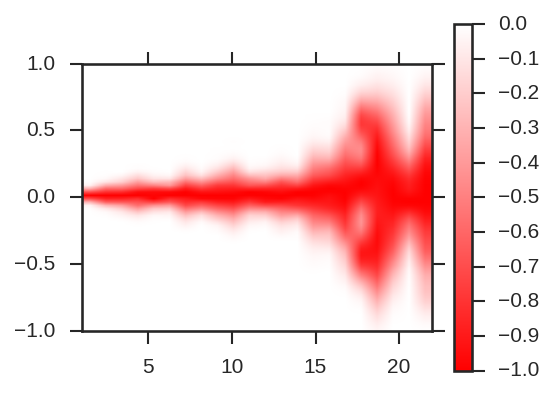

In [379]:
# Better Gaussian KDE fit to distribution at each value of x
Z = Q_xy_V3["Naive"]["IgA1"]
bins = (np.arange(0, max(Z[0])), np.arange(-1, 1, 0.025))
fig, ax = plt.subplots(1, 1, figsize=(4,3))
im = hist2d_xGaussian(Z[0], Z[1], ax, bins=bins, cmap=RedWhite)
plt.colorbar(im)
plt.tight_layout()

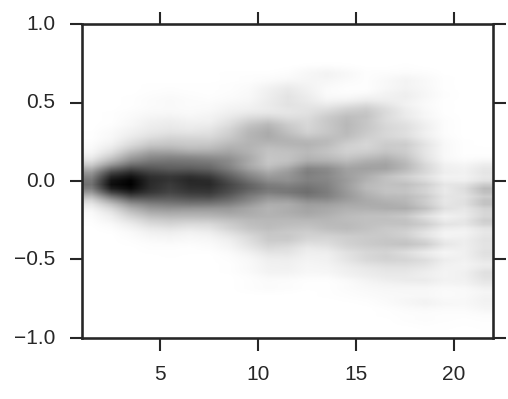

In [263]:
# Simple gaussian smoothing applied to entire image
Z = Q_xy_V3["Naive"]["IgA2"]
bins = (np.arange(0, max(Z[0])), np.arange(-1, 1, 0.025))
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = gaussian_hist2d(Z[0], Z[1], ax, bins=bins)
plt.tight_layout()

In [462]:
# Plot for only Naive cells with density plot of shuffled lines
def plot_Q_by_bin_oneIsotype_density(df_Qs, Q_xy_shuffleds, from_isotype, bin_by):
    
    to_isotypes = ["IgG1", "IgA1", "IgG2", "IgA2"]
    isotype_to_col_num = dict(zip(to_isotypes, range(len(to_isotypes))))
    
    sns.set_style("ticks")
    
    fig, axes = plt.subplots(2, 4, figsize=(8, 3.4), sharex=True, sharey=True)
    
    for to_isotype in to_isotypes:
        
        col_num = isotype_to_col_num[to_isotype]
        
        rows = [0, 1]
        for i in rows:
            
            ax = axes[i, col_num]
            df_Q = df_Qs[i]
            Q_xy_shuffled = Q_xy_shuffleds[i]

            myData = df_Q[df_Q["isotype"] == from_isotype][df_Q["destination_isotype"] == to_isotype]
            x = myData[bin_by]
            y = myData.Q
            ax.plot(x, y, c='k', marker='.', linewidth=1, label="Data")
            
            # Plot shuffled pairs
            Z = Q_xy_shuffled[from_isotype][to_isotype]
            bins = (np.arange(-1, max(Z[0] * 2)), np.arange(-1, 1, 0.025))
            im = hist2d_xGaussian(Z[0], Z[1], ax, bins=bins, cmap=RedWhite)
            
    for i, ax_row in enumerate(axes):
        for ax in ax_row:
            ax.set_adjustable('box-forced')
            sns.despine()
            xticks = ax.get_xticks()
            # print xticks
            yticks = ax.get_yticks()
            ax.set_ylim(yticks[0]-0.1,yticks[-1]+0.1)
            ax.set_yticks(yticks)
            ax.set_xlim(0, 25)
            ax.set_xticklabels([0, 10, 20, 30, 40, 50])

    for ax, to_isotype in zip(axes[0], to_isotypes):
        ax.set_title(from_isotype.replace("Naive", "IgM/IgD") + " -> " + to_isotype)
    
    fig.text(0.5, -0.02, "Mutations from MRCA", ha='center', size=12)
    fig.text(-0.015, 0.5, "Yule's Q", va='center', rotation='vertical', size=12)

    # axes[-1, -1].plot(-1, -1, linestyle="none", marker="None", color="#000000", label="Shuffled")
    axes[-1, -1].legend(bbox_to_anchor = (0.9, 0.9, 1, 1), prop={'size':12})    
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.07, 0.28, 0.02, 0.25])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.invert_yaxis()
    cbar.set_ticks([-1, 0])
    cbar.set_ticklabels([1, 0])
    cbar.ax.set_ylabel('Density', rotation=270)
    axes[0, -1].text(35, -0.95, "Shuffled", fontsize=12) # x = 40 is aligned with "Data"
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.1)
    
    return fig, axes

In [ ]:
fig, axes = plot_Q_by_bin_oneIsotype_density([df_Q_max_sib_dist_bin_V1, df_Q_max_sib_dist_bin_V3],
                                             [Q_xy_V1, Q_xy_V3],
                                             from_isotype="Naive", bin_by="max_sib_dist_bin")

fig.text(0.98, 0.76, "Sample", va='center', rotation=270, size=12)
fig.text(0.98, 0.31, "Bio. Rep.", va='center', rotation=270, size=12)

if savefig: save_figure(fig, "yulesQ_vs_max_sib_dist_bin_Naive_density", output_dir, output_suffix, output_formats, savefig_args)

# Plot Yule's Q for most closely related cells (by mutational distance)

In [17]:
df_Q_V1 = df_Q_max_sib_dist_bin_V1
df_Q_V3 = df_Q_max_sib_dist_bin_V3

df_Q_V1["visit"] = "V1"
df_Q_V3["visit"] = "V3"

df_Q = pd.concat([df_Q_V1, df_Q_V3])

In [20]:
df_Q_shuffleds = {"V1": df_Q_max_sib_dist_bin_V1_shuffleds, "V3": df_Q_max_sib_dist_bin_V3_shuffleds}

In [21]:
def plot_Q_top_bin_with_shuffles(df_Q, df_Q_shuffleds, bin_by):
    
    # Filter for top bin and sufficiently large sample
    df = df_Q.loc[df_Q[bin_by] == 1]
    df = df.loc[df['num_cases'] >= 100]
    
    # Sort
    df["isotype"] = pd.Categorical(df["isotype"], isotype_names)
    df["destination_isotype"] = pd.Categorical(df["destination_isotype"], isotype_names)
    df["visit"] = pd.Categorical(df["visit"], ["V1", "V2", "V3"])
    df.sort(["isotype", "destination_isotype", "visit"], inplace=True)
    
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    
    # Plot
    sns.set_style("ticks")
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))

    X = []
    Y = []
    visits = []
    labels = []
    
    isotypes = []
    destination_isotypes = []
    
    visit_to_color = {"V1": "w", "V2": "#bdbdbd", "V3": "k"}
    
    i = 0
    prev_isotype = ""
    prev_destination_isotype = ""
    
    for _, row in df.iterrows():
        
        if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue

        if row.isotype != prev_isotype or row.destination_isotype != prev_destination_isotype:
            i += 3
            prev_isotype = row.isotype
            prev_destination_isotype = row.destination_isotype
        else:
            i += 1
        
        X.append(i)
        Y.append(float(row.Q))
        
        visits.append(row.visit)
        
        label = row.isotype + " -> " + row.destination_isotype
        label = label.replace("Naive", "IgM/IgD")
        labels.append(label)
        
        isotypes.append(row.isotype)
        destination_isotypes.append(row.destination_isotype)
        
    colors = [visit_to_color[v] for v in visits]
    ax.scatter(X, Y, c=colors, s=30, zorder=10)
    
    bounds = True
    if bounds:
        # Plot bounds from shuffled data
        for x, v, isotype, destination_isotype in zip(X, visits, isotypes, destination_isotypes):

            if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue

            shuffleds = df_Q_shuffleds[v]
            Qs = []

            for i in range(len(shuffleds)):
                df = shuffleds[i]
                a = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].a
                Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
    #             if len(a) > 0:
    #                 if int(a) > 1 and len(Q) > 0:
    #                     Qs.append(float(Q))
                if len(Q) > 0: Qs.append(float(Q))

            if len(Qs) > 0:
                mean = np.mean(Qs)
                std = np.std(Qs)
                lower = mean - std
                upper = mean + std
                ax.errorbar([x], [mean], yerr=[[mean-lower],[upper-mean]], c="k", linewidth=1, capthick=1, zorder=1)
                print x, v, isotype, destination_isotype, len(Qs)
            else:
                print "x, v, isotype, destination_isotype"
                print x, v, isotype, destination_isotype
                print "has len(Q) == 0 for shuffled sets"
                print

    ax.set_xlim(min(X)-1, max(X)+1)
    ax.set_ylim(-1.05, 1.05)

    ax.set_ylabel("Yule's Q")
    
    ax.xaxis.tick_top()

    # All ticks
    # ax.set_xticks(X)
    # ax.set_xticklabels(labels, rotation=45, ha="right")
    
    # Nonredundant ticks
    num_visits = len(df_Q["visit"].unique())
    if num_visits == 2:
        xtick_offset = 0.5
    else:
        xtick_offset = 0
    X_nonredundant = list(np.array(X[0::num_visits]) + xtick_offset)
    labels_nonredundant = labels[0::num_visits]
    ax.set_xticks(X_nonredundant)
    ax.set_xticklabels(labels_nonredundant, rotation=45, ha="left")

    ax.yaxis.set_ticks_position('left')
    
    plt.tight_layout()
    
    return fig, ax

3 V1 Naive IgG1 1000
4 V3 Naive IgG1 1000
7 V1 Naive IgA1 1000
8 V3 Naive IgA1 1000
11 V1 Naive IgG2 1000
12 V3 Naive IgG2 1000
15 V1 Naive IgA2 1000
16 V3 Naive IgA2 1000
19 V1 IgG1 IgA1 1000
20 V3 IgG1 IgA1 1000
23 V1 IgG1 IgG2 1000
24 V3 IgG1 IgG2 1000
27 V1 IgG1 IgA2 997
28 V3 IgG1 IgA2 1000
31 V1 IgA1 IgG2 1000
32 V3 IgA1 IgG2 1000
35 V1 IgA1 IgA2 1000
36 V3 IgA1 IgA2 1000
39 V1 IgG2 IgA2 1000
40 V3 IgG2 IgA2 998


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


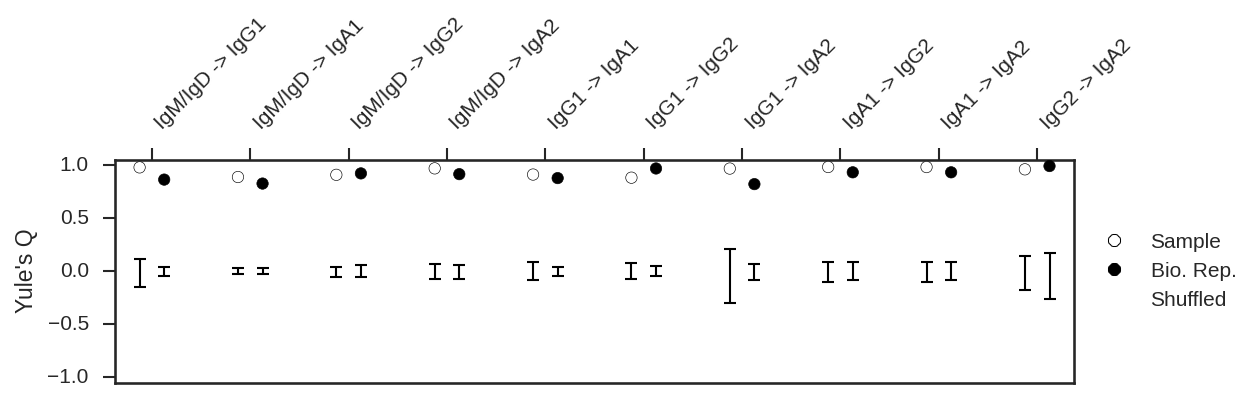

In [24]:
# All visits
fig, ax = plot_Q_top_bin_with_shuffles(df_Q, df_Q_shuffleds, bin_by="max_sib_dist_bin")

ax.plot(-1, -1, linestyle="none", marker="o", color="#ffffff", markeredgewidth=0.5, markersize=6, label="Sample")
ax.plot(-1, -1, linestyle="none", marker="o", color="#000000", markeredgewidth=0.5, markersize=6, label="Bio. Rep.")
ax.plot(-1, -1, linestyle="none", marker="None", color="#000000", markeredgewidth=0.5, markersize=6, label="Shuffled")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

if savefig: save_figure(fig, "yulesQ_max_sib_dist_topBin", output_dir, output_suffix, output_formats, savefig_args)

# Examine shuffled Qs to see if they are Gaussian

In [119]:
# Define model function to be used to fit to the data
def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

In [120]:
def plot_Q_hist(df_shuffleds, isotype, destination_isotype, bin_by):

    # Get values of Q
    Qs = []
    for i in range(len(df_shuffleds)):
        df = df_shuffleds[i]
        Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
        if len(Q) > 0: Qs.append(float(Q))

    print "Number of Q:", len(Qs)

    # Fit histogram with Gaussian
    hist, bin_edges = np.histogram(Qs, bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    coeff, var_matrix = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=p0)
    hist_fit = gaussian(bin_centers, *coeff)

    # Plot histogram and Gaussian fit
    sns.set_style("ticks")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    
    width = 0.7 * (bin_centers[1] - bin_centers[0])
    
    ax.bar(bin_centers, hist, align="center", width=width, label='Data')
    ax.plot(bin_centers, hist_fit, c="red", label='Fit')
    
    ax.set_xlim(min(bin_centers)-0.1, max(bin_centers)+0.1)
    
    ax.set_xlabel("Q")
    ax.set_ylabel("Count")
    
    ax.set_title(isotype.replace("Naive", "IgM/IgD") + " -> " + destination_isotype)
    
    ax.legend(loc="upper right")
    
    sns.despine()
    plt.tight_layout()
    
    return fig, ax, Qs

Number of Q: 1000


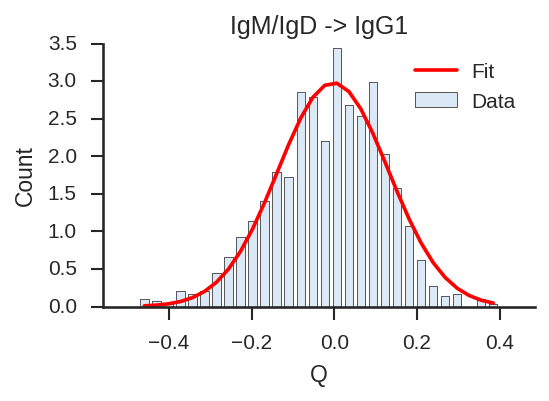

In [121]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgG1", bin_by="max_sib_dist_bin")

Number of Q: 1000


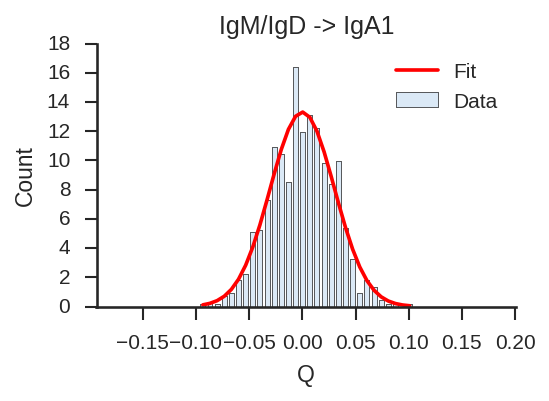

In [127]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgA1", bin_by="max_sib_dist_bin")

Number of Q: 1000


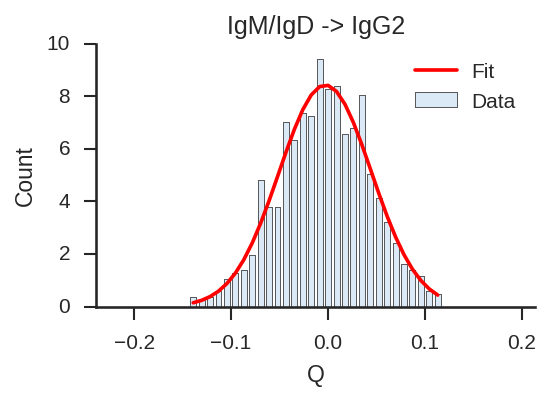

In [128]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgG2", bin_by="max_sib_dist_bin")

Number of Q: 1000


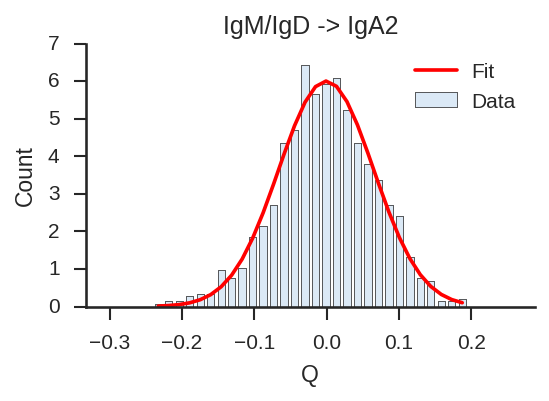

In [129]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgA2", bin_by="max_sib_dist_bin")

Number of Q: 1000


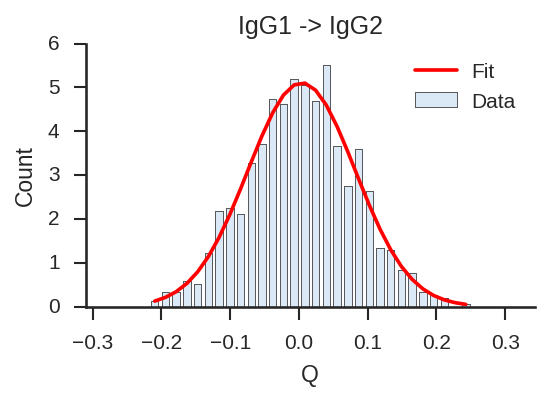

In [130]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "IgG1", "IgG2", bin_by="max_sib_dist_bin")

Number of Q: 1000


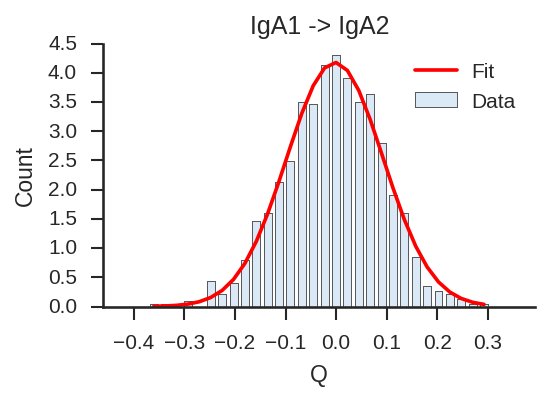

In [131]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "IgA1", "IgA2", bin_by="max_sib_dist_bin")

Number of Q: 997


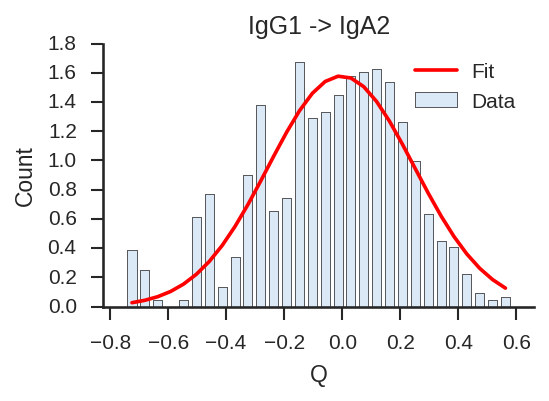

In [132]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "IgG1", "IgA2", bin_by="max_sib_dist_bin")

Number of Q: 1000


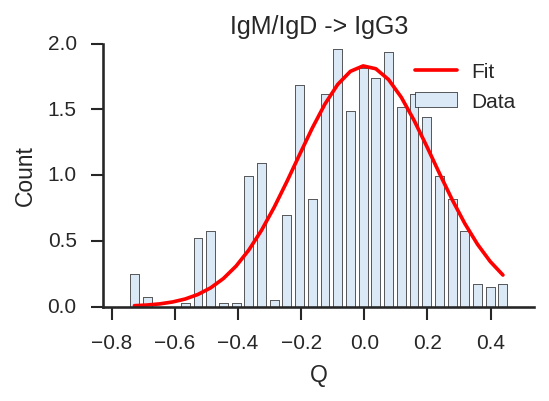

In [133]:
fig, ax, Qs = plot_Q_hist(df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgG3", bin_by="max_sib_dist_bin")

Yes, these are Gaussian! We can fit Gaussians and compute an exact P value. Examples of fit Gaussians are overlaid in red.

# Calculate exact P values for observed Q by fitting Gaussians

In [135]:
def calc_Pvalues_Q_with_shuffles(df_Q, df_Q_shuffleds, bin_by):
    
    # Filter for top bin and sufficiently large sample
    df = df_Q.loc[df_Q[bin_by] == 1]
    df = df.loc[df['num_cases'] >= 100]
    
    # Sort
    df["isotype"] = pd.Categorical(df["isotype"], isotype_names)
    df["destination_isotype"] = pd.Categorical(df["destination_isotype"], isotype_names)
    df["visit"] = pd.Categorical(df["visit"], ["V1", "V2", "V3"])
    df.sort(["isotype", "destination_isotype", "visit"], inplace=True)
    
    # Load values of Q
    X = []
    Y = []
    visits = []
    labels = []
    
    isotypes = []
    destination_isotypes = []
        
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    
    visit_to_day = {"V1": "Sample", "V2": "D7", "V3": "Bio. Rep."}

    for i, (_, row) in enumerate(df.iterrows()):
    
        if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue
        
        X.append(i)
        Y.append(float(row.Q))
        
        visits.append(row.visit)
        
        label = row.isotype + " -> " + row.destination_isotype
        labels.append(label)
        
        isotypes.append(row.isotype)
        destination_isotypes.append(row.destination_isotype)
    
    # Load shuffled data, fit Gaussian, plot shuffled data, fit, and observed value, compute exact P value
    for x, y, v, isotype, destination_isotype in zip(X, Y, visits, isotypes, destination_isotypes):
        
        shuffleds = df_Q_shuffleds[v]
        Qs = []
        
        for i in range(len(shuffleds)):
            df = shuffleds[i]
            Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
            if len(Q) > 0: Qs.append(float(Q))

        # Fit histogram with Gaussian
        hist, bin_edges = np.histogram(Qs, bins=20, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

        coeff, var_matrix = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=p0)
        hist_fit = gaussian(bin_centers, *coeff)

        # Compute P value of observed x
        A, mu, sigma = coeff
        P = scipy.stats.norm(loc=mu, scale=np.absolute(sigma)).sf(y)
        
        print isotype, destination_isotype, v, "Q = %.2f" % y, "mu = %.2e" % mu, "sigma = %.2e" % sigma, "P = %.2e" % P
        
        # Plot histogram and Gaussian fit
        sns.set_style("ticks")

        fig, ax = plt.subplots(1, 1, figsize=(4,3))

        width = 0.7 * (bin_centers[1] - bin_centers[0])

        ax.bar(bin_centers, hist, align="center", width=width, label='Shuffles')
        ax.plot(bin_centers, hist_fit, c="red", label='Fit')
        ax.scatter(y, 0.1, marker="o", c="k", label='Observed', s=10, zorder=10)
        
        ax.set_ylim(bottom=0)

        ax.set_xlabel("Q")
        ax.set_ylabel("Density")
        title = isotype.replace("Naive", "IgM/IgD") + " -> " + destination_isotype + ", " + visit_to_day[v] + ", P = %.2e" % P
        ax.set_title(title)
        ax.legend(loc="upper right")

        sns.despine()
        plt.tight_layout()
        
    return fig, ax

Naive IgG1 V1 Q = 0.98 mu = -3.71e-03 sigma = -1.37e-01 P = 3.32e-13
Naive IgG1 V3 Q = 0.86 mu = 1.15e-03 sigma = -4.49e-02 P = 1.94e-82
Naive IgA1 V1 Q = 0.89 mu = 1.46e-04 sigma = -3.04e-02 P = 1.09e-186
Naive IgA1 V3 Q = 0.83 mu = 6.98e-04 sigma = -3.15e-02 P = 3.73e-151
Naive IgG2 V1 Q = 0.91 mu = -2.82e-03 sigma = -4.74e-02 P = 2.01e-82
Naive IgG2 V3 Q = 0.92 mu = 1.82e-03 sigma = -5.52e-02 P = 1.49e-62
Naive IgA2 V1 Q = 0.97 mu = -5.38e-04 sigma = -6.62e-02 P = 9.15e-49
Naive IgA2 V3 Q = 0.91 mu = -2.74e-03 sigma = 6.73e-02 P = 1.50e-42
IgG1 IgA1 V1 Q = 0.91 mu = 5.27e-03 sigma = -8.71e-02 P = 1.40e-25
IgG1 IgA1 V3 Q = 0.88 mu = -9.49e-04 sigma = -4.34e-02 P = 2.36e-91
IgG1 IgG2 V1 Q = 0.88 mu = 2.92e-03 sigma = -7.85e-02 P = 2.53e-29
IgG1 IgG2 V3 Q = 0.97 mu = 7.35e-04 sigma = -4.99e-02 P = 7.75e-84
IgG1 IgA2 V1 Q = 0.97 mu = -4.38e-03 sigma = -2.52e-01 P = 5.88e-05
IgG1 IgA2 V3 Q = 0.82 mu = -3.16e-03 sigma = -7.91e-02 P = 1.25e-25
IgA1 IgG2 V1 Q = 0.98 mu = -8.68e-04 sigma = -

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(<matplotlib.figure.Figure at 0x7f201b76e8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f201299c510>)

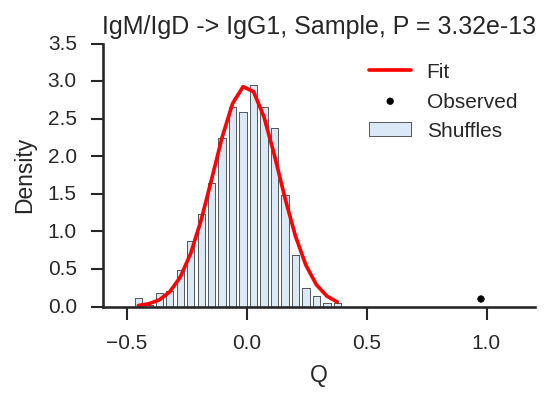

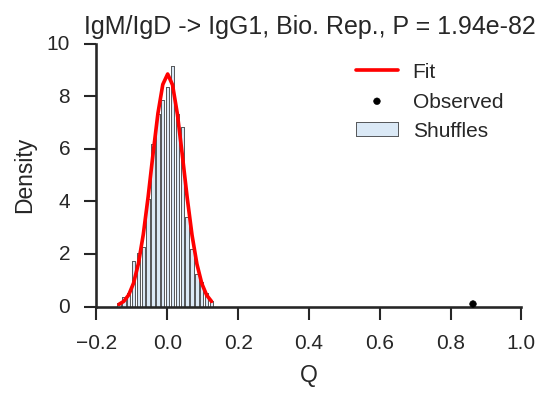

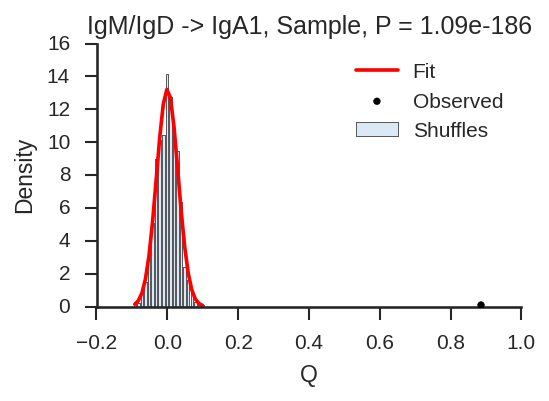

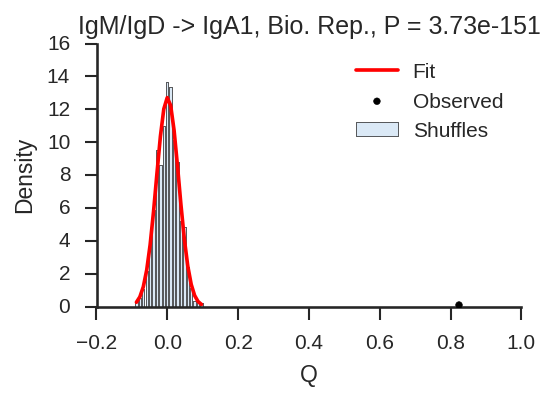

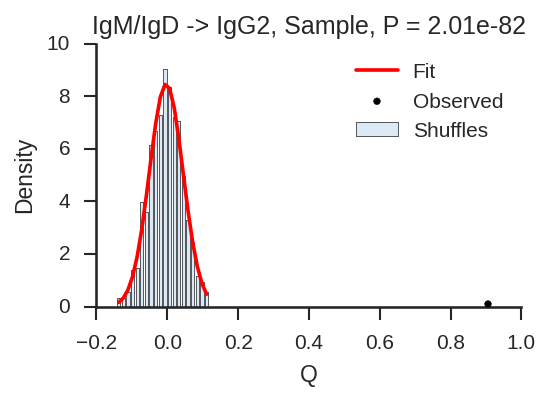

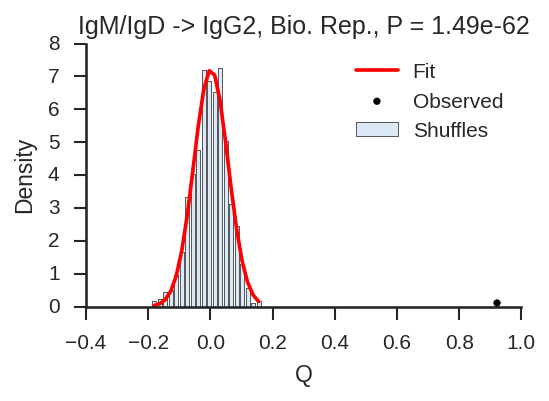

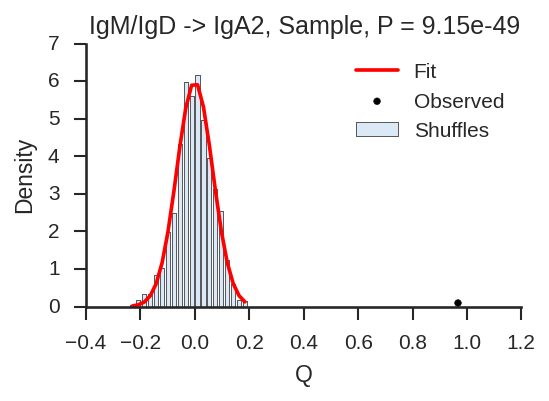

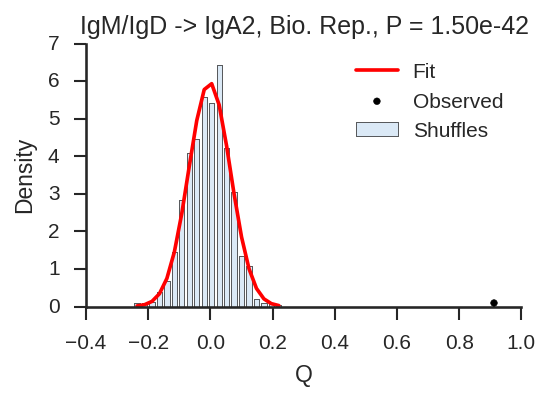

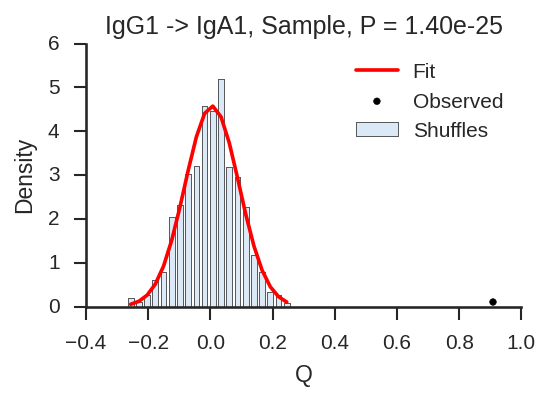

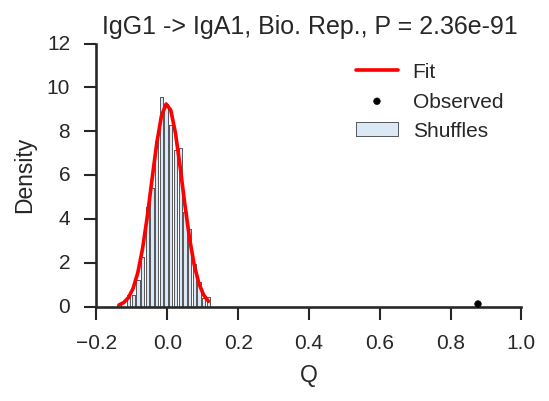

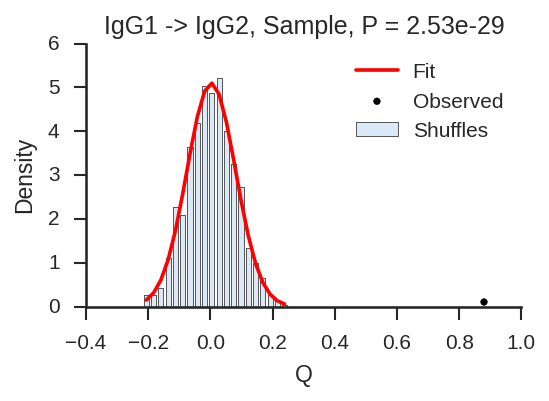

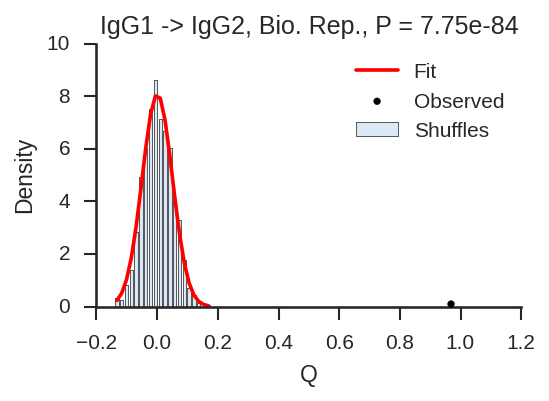

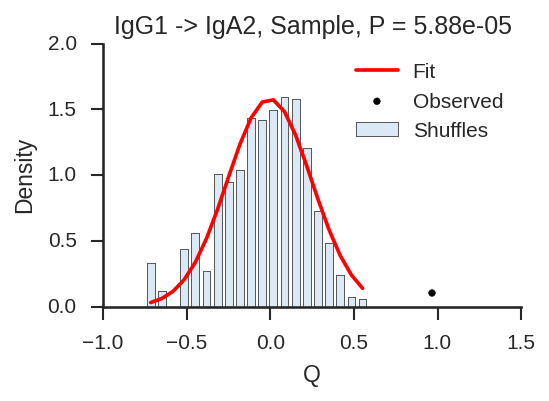

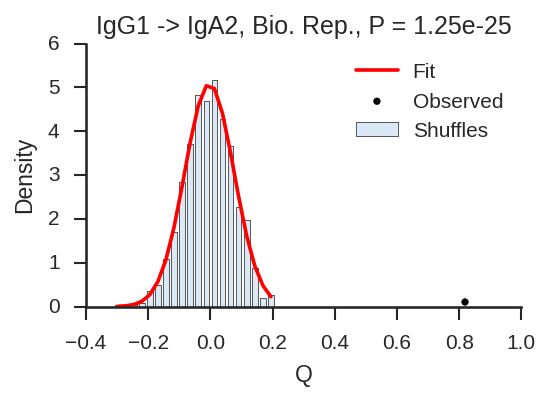

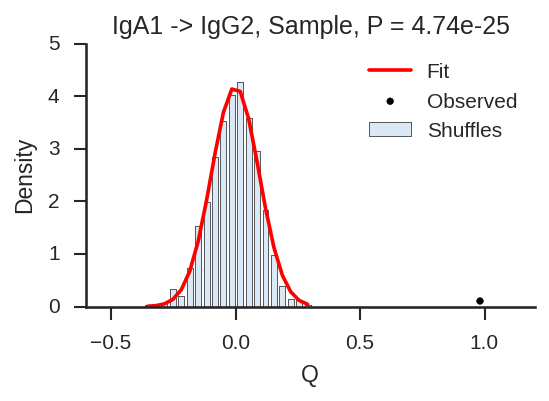

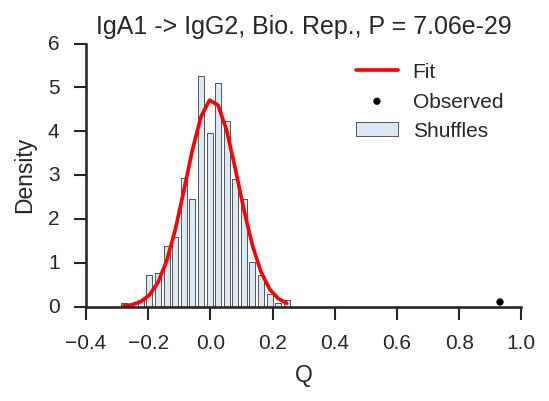

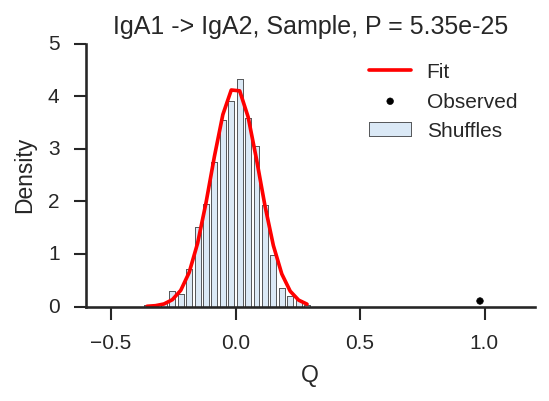

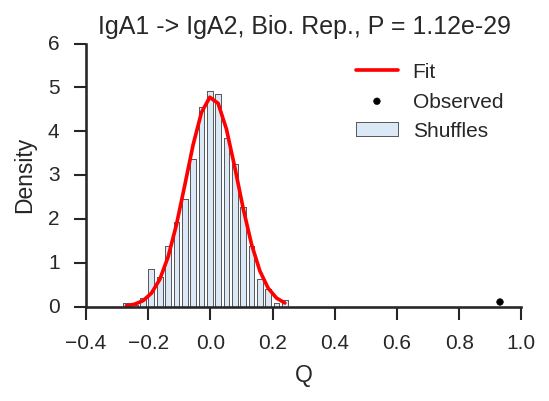

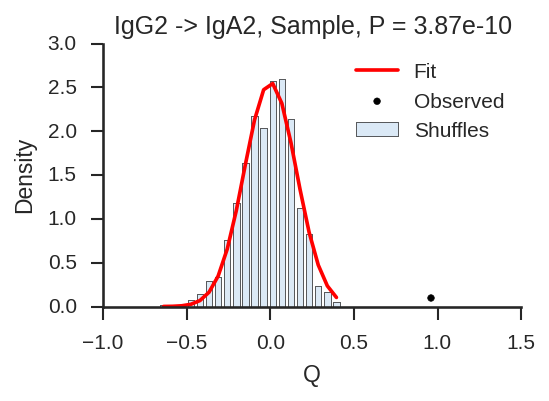

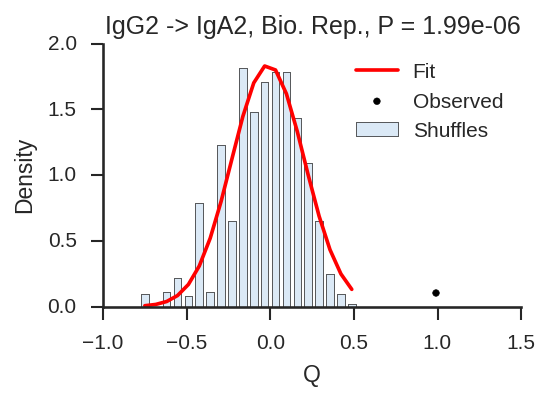

In [137]:
calc_Pvalues_Q_with_shuffles(df_Q, df_Q_shuffleds, bin_by="max_sib_dist_bin")

In [ ]:
# Do mutations before switch correlate between two relatives? No.
plt.scatter(df_V1.sib1_switch_dist, df_V1.sib2_switch_dist)
plt.scatter(df_V3.sib1_switch_dist, df_V3.sib2_switch_dist)